In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "dropout_estimate"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0
ccd.ul.set_seed(seed)

In [25]:
data_paths = {
    "pancreas": "../data/pancreas/dataset.h5ad",
    "lung": "../data/lung_atlas/Lung_atlas_public.h5ad",
    "intestine": "../data/intestine_dev/adata_huycke_Jan08-1324.h5ad",
    "C.elegans": "../data/celegans_data/adata_pknn_Jan23-1836.h5ad"
}

In [16]:
adata.layers

Layers with keys: counts

In [24]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 87287632 stored elements and shape (96084, 20222)>

In [26]:
from Concord.model.knn import Neighborhood
import numpy as np
import pandas as pd

# compute avg distance for each dataset, save result to pandas dataframe
distance_res = {}
for dataset in data_paths:
    adata = sc.read(data_paths[dataset])
    if dataset in ['pancreas', 'lung']:
        # Compute PCA
        adata.X = adata.layers['counts']
        sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
        sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

    emb = adata.obsm['X_pca']
    neighborhood = Neighborhood(emb=emb, k=3)
    core_samples = np.array([1])
    # Sample 300 cells to calculate the average distance
    core_samples = np.random.choice(emb.shape[0], 300, replace=False)
    X = adata.layers['counts'].toarray()
    avg_distances = neighborhood.average_knn_distance(core_samples, X, k=3, distance_metric='drop_diff')
    distance_res[dataset] = avg_distances

dropout_df = pd.DataFrame(distance_res)
dropout_df


Concord.model.knn - INFO - Using euclidean distance metric.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.knn - INFO - Using euclidean distance metric.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.knn - INFO - Using euclidean distance metric.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.knn - INFO - Using euclidean distance metric.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.


pancreas      lung  intestine  C.elegans
0    0.552437  0.474511   0.752033   0.601156
1    0.722652  0.403184   0.242960   0.582781
2    0.622365  0.612669   0.445905   0.754348
3    0.637441  0.663459   0.384790   0.646648
4    0.667423  0.583063   0.736842   0.625000
..        ...       ...        ...        ...
295  0.496568  0.833977   0.617695   0.723282
296  0.539842  0.394397   0.411254   0.492003
297  0.624406  0.742690   0.721440   0.599603
298  0.638020  0.530530   0.551939   0.665700
299  0.433076  0.633791   0.578833   0.505105

[300 rows x 4 columns]

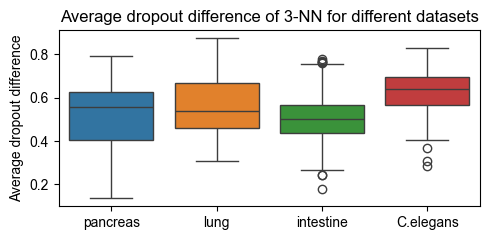

In [34]:
# Plot box plot of the dropout_df
import matplotlib.pyplot as plt
import seaborn as sns
with plt.rc_context(rc=custom_rc):
    plt.figure(figsize=(5, 2.5))
    sns.boxplot(data=dropout_df)
    plt.ylabel("Average dropout difference")
    plt.title("Average dropout difference of 3-NN for different datasets")
    plt.tight_layout()
    plt.savefig(save_dir / f"avg_distance_boxplot_{file_suffix}.pdf")
    plt.show()


In [5]:
adata.X = adata.layers["counts"].copy()
feature_list = ccd.ul.select_features(adata, n_top_features=3000, flavor='seurat_v3', normalize=False, log1p=False)
adata = adata[:, feature_list]
adata.X = adata.layers["log_normalized"].copy()
adata.obs['log_ncounts'] = np.log1p(adata.obs['n_counts'])

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...


Load previous results.

In [6]:
adata.obsm = ccd.ul.load_obsm_from_hdf5(Path('../save/dev_human_pancreas_benchmarking-Oct10/') / "obsm_human_pancreas_benchmarking_Oct10-1845.h5")
adata.obsm

AxisArrays with keys: Concord, Concord_UMAP, Concordant, Concordant-leiden, Concordant_UMAP, Harmony, Harmony_UMAP, LIGER, LIGER_UMAP, Scanorama, Scanorama_UMAP, Unintegrated, X_pca, X_umap, scANVI, scANVI_UMAP, scVI, scVI_UMAP

### No correction

In [15]:
sc.tl.pca(adata, n_comps=30)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, min_dist=0.1)

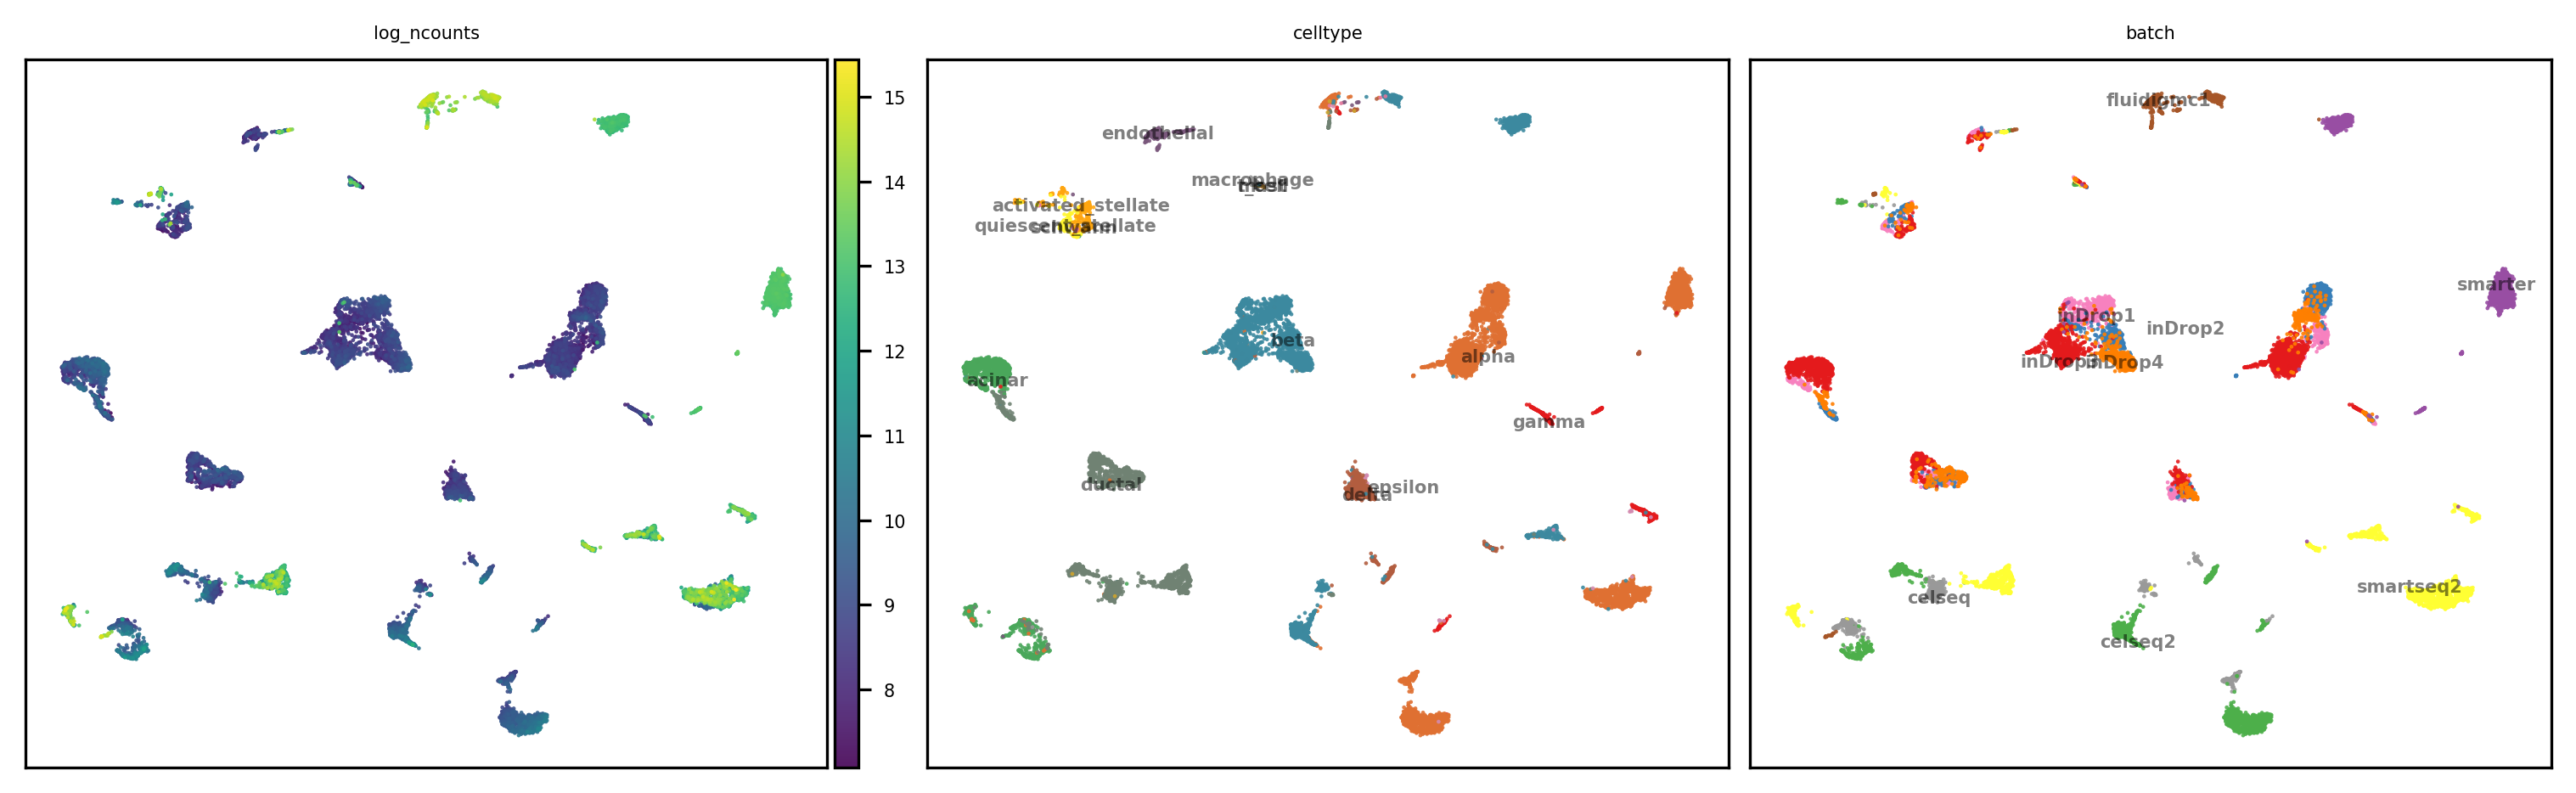

In [16]:
show_basis = 'X_umap'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [7]:
file_suffix = f"{time.strftime('%b%d-%H%M')}"
ccd.set_verbose_mode(True)
state_key = 'cell_type'
batch_key= 'batch'
show_cols = [state_key, batch_key]
timer = ccd.ul.Timer()
time_log = {}

### Scanorama

In [11]:
output_key = 'Scanorama'

with timer:
    ccd.ul.run_scanorama(adata, batch_key="batch", output_key=output_key, return_corrected=False)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

Found 3000 genes among all datasets
[[0.         0.6547046  0.02037618 0.20185854 0.1374502  0.0189243
  0.03386454 0.03784861 0.3436255 ]
 [0.         0.         0.11128527 0.0547238  0.01218097 0.
  0.00690714 0.02546917 0.59212254]
 [0.         0.         0.         0.01253918 0.0031348  0.00626959
  0.0015674  0.63949843 0.03134796]
 [0.         0.         0.         0.         0.60041301 0.56943727
  0.35379893 0.01445534 0.01600413]
 [0.         0.         0.         0.         0.         0.42343387
  0.75058005 0.01798144 0.08352668]
 [0.         0.         0.         0.         0.         0.
  0.56715272 0.0074896  0.01420217]
 [0.         0.         0.         0.         0.         0.
  0.         0.1181888  0.12356101]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.58512064]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
Processing datasets (4, 6)
Processing datasets (0, 1)
Processing dat

Concord - INFO - UMAP embedding stored in adata.obsm['Scanorama_UMAP']


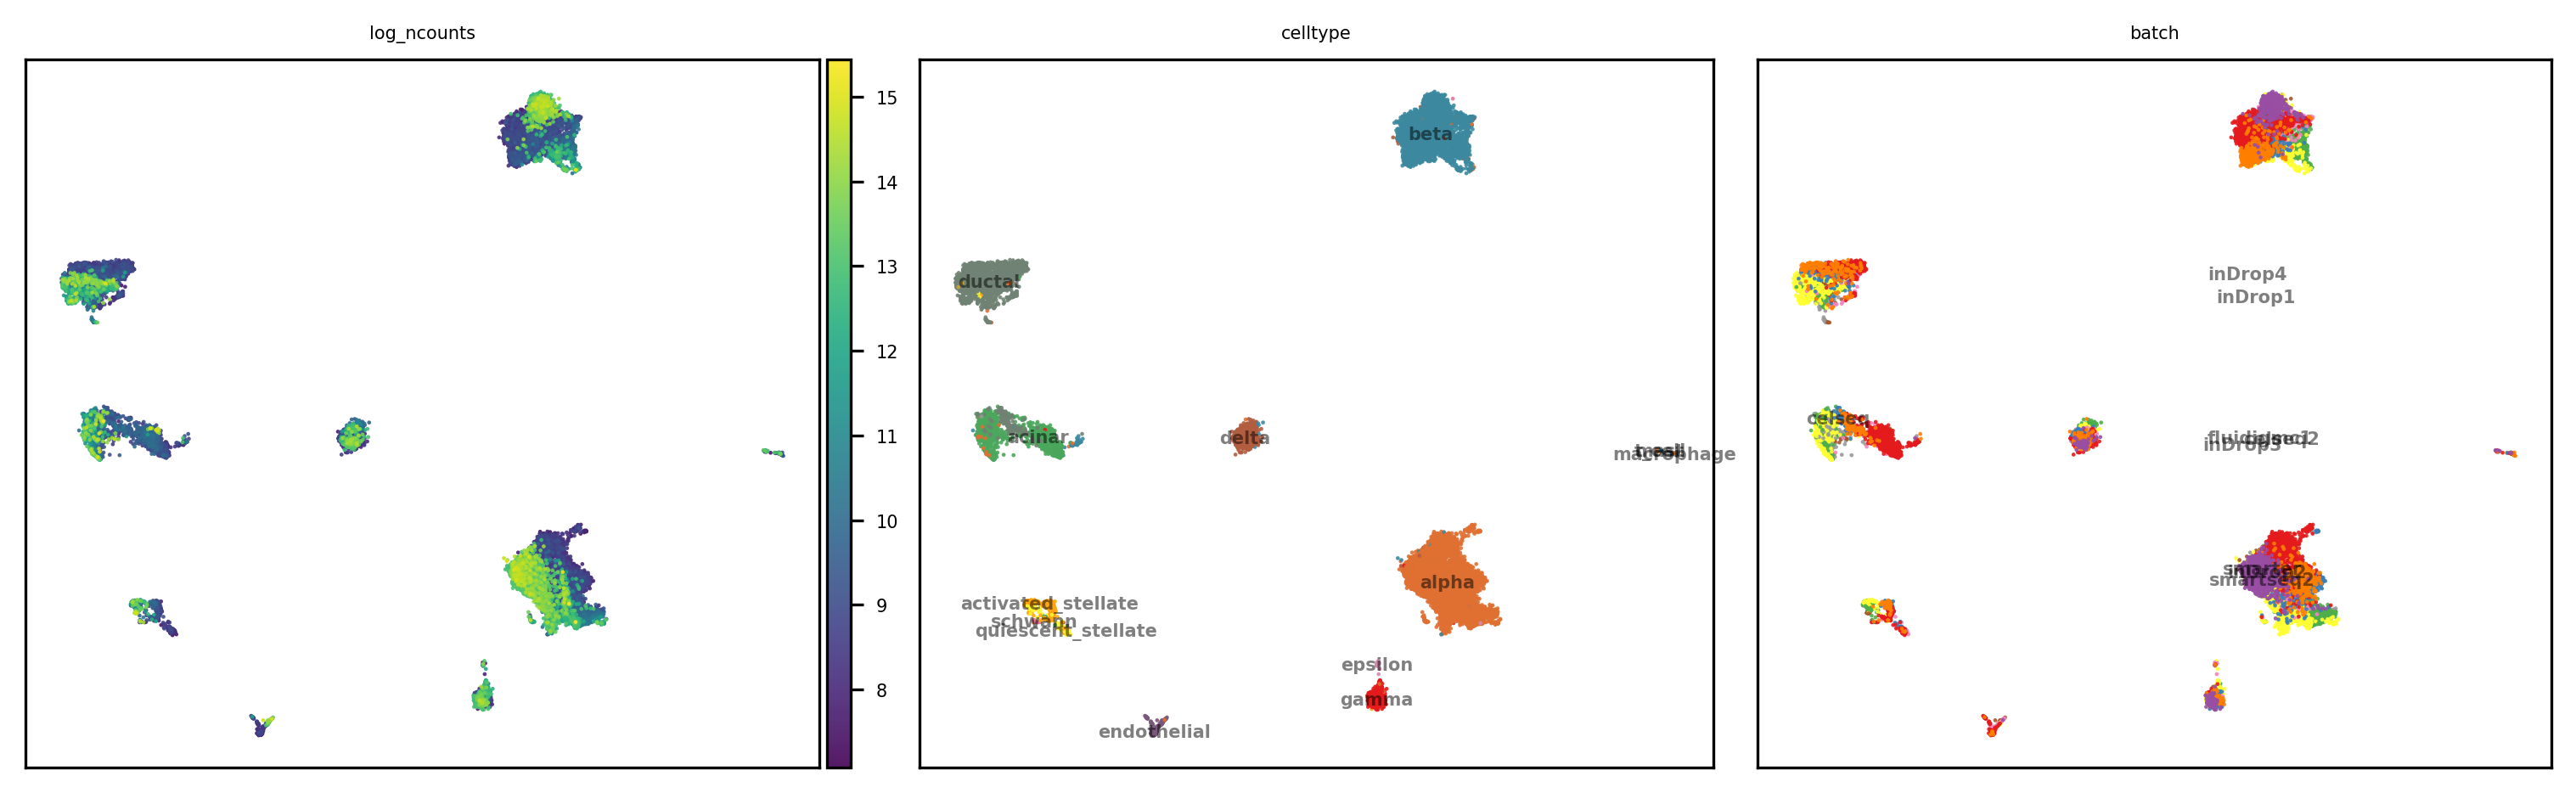

In [ ]:
output_key = 'Scanorama'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

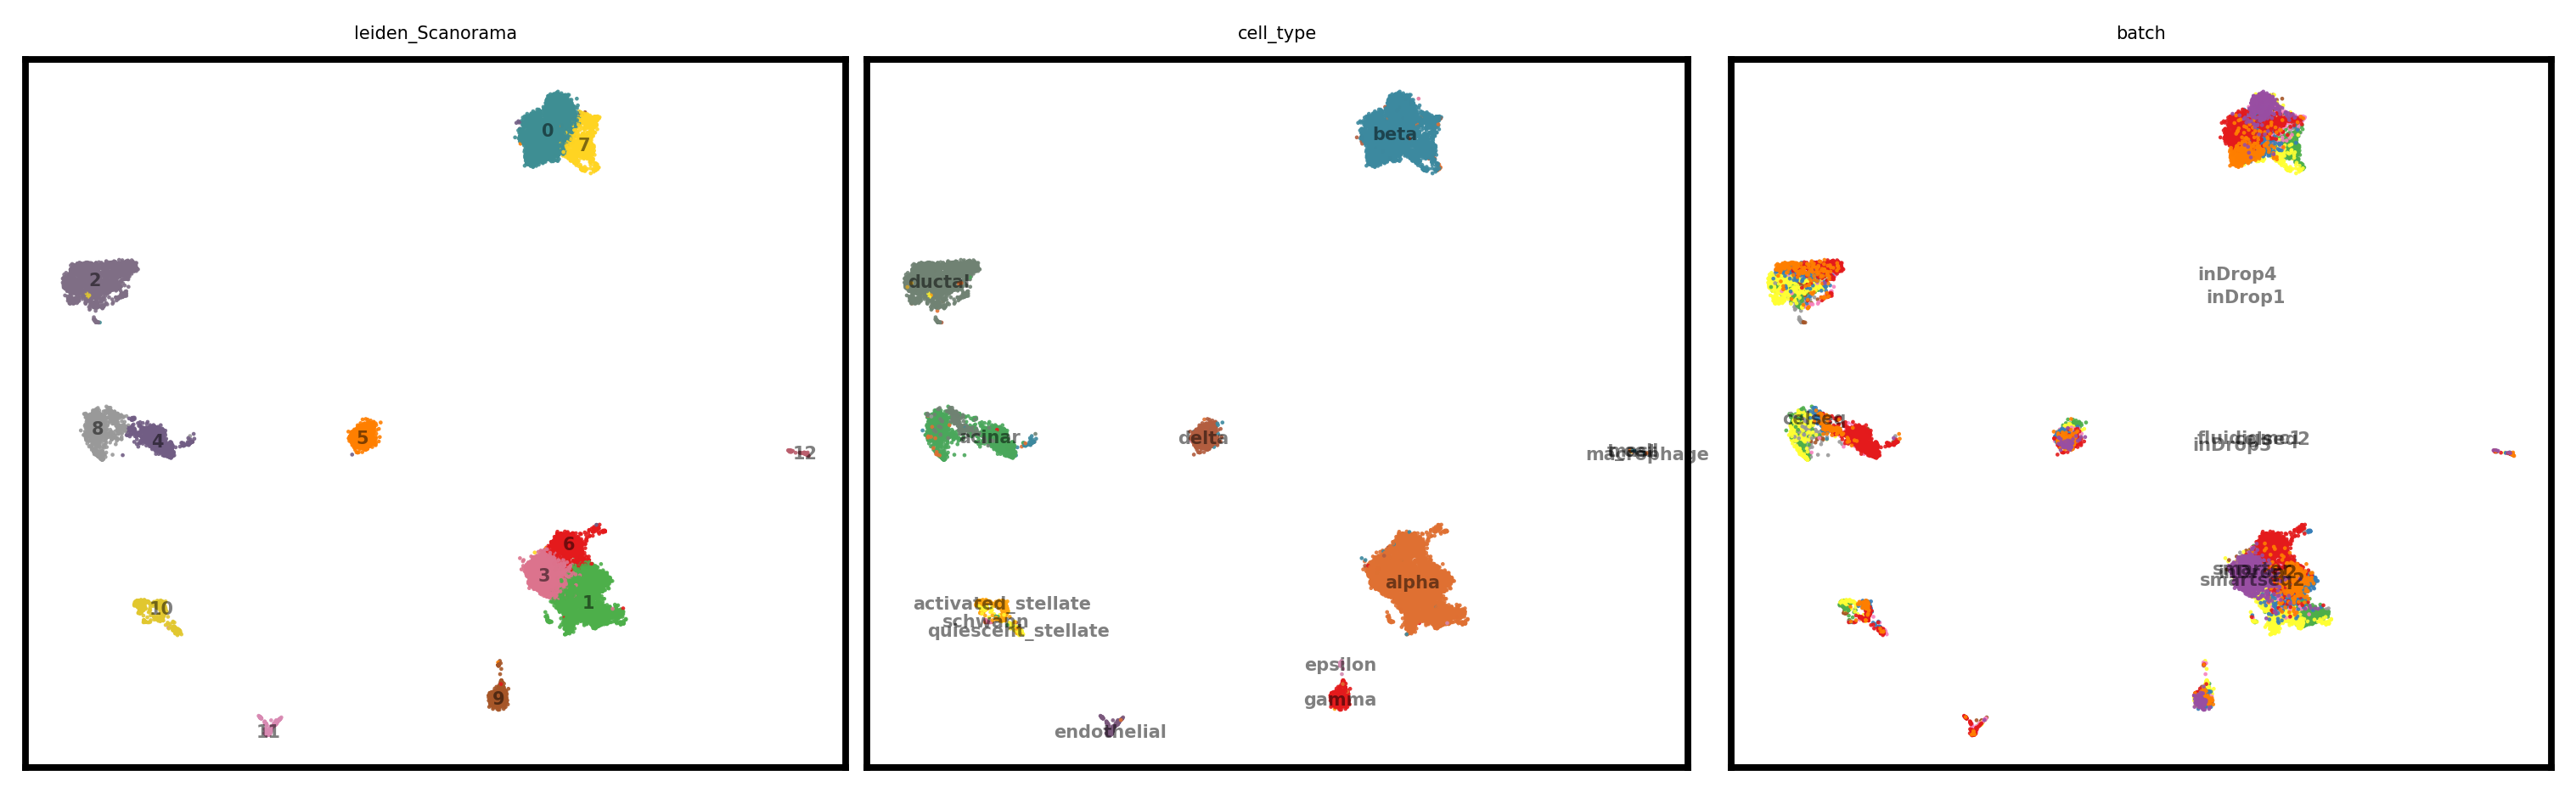

isolated labels: no more than 4 batches per label
t_cell: 0.5419180134118197
isolated labels: no more than 4 batches per label
Compute neighbors on rep Scanorama


t_cell: 0.1037037037037037
NMI: 0.800, ARI: 0.620, isolated_labels_asw: 0.542, isolated_labels_f1: 0.104, silhouette: 0.582


In [82]:
import scib
output_key = 'Scanorama'
cluster_key = f'leiden_{output_key}'
label_key = 'cell_type'
sc.pp.neighbors(adata, n_neighbors=30, use_rep=output_key, metric='euclidean')
sc.tl.leiden(adata, resolution=1.0, key_added=cluster_key)
show_basis = f'{output_key}_UMAP'
show_cols = [cluster_key, label_key, 'batch']

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_leiden_{show_basis}_{file_suffix}.png"
)
nmi_val = scib.metrics.nmi(adata, cluster_key, label_key)
ari_val = scib.metrics.ari(adata, cluster_key, label_key)
label_asw = scib.metrics.isolated_labels_asw(adata, label_key, batch_key, embed = output_key)
label_f1 = scib.metrics.isolated_labels_f1(adata, label_key, batch_key, embed = output_key)
silhouette = scib.me.silhouette(adata, label_key=label_key, embed=output_key)
print(f"NMI: {nmi_val:.3f}, ARI: {ari_val:.3f}, isolated_labels_asw: {label_asw:.3f}, isolated_labels_f1: {label_f1:.3f}, silhouette: {silhouette:.3f}")

In [ ]:
import scib
output_key = 'Concord'
cluster_key = f'leiden_{output_key}'
label_key = 'cell_type'
sc.pp.neighbors(adata, n_neighbors=30, use_rep=output_key, metric='euclidean')
sc.tl.leiden(adata, resolution=0.1, key_added=cluster_key)
show_basis = f'{output_key}_UMAP'
show_cols = [cluster_key, label_key, 'batch']

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_leiden_{show_basis}_{file_suffix}.png"
)
nmi_val = scib.metrics.nmi(adata, cluster_key, label_key)
ari_val = scib.metrics.ari(adata, cluster_key, label_key)
#silhouette = scib.me.silhouette(adata, label_key=label_key, embed=output_key)
print(f"NMI: {nmi_val:.3f}, ARI: {ari_val:.3f}")

### Liger

In [41]:
output_key = 'Liger'
with timer:
    ccd.ul.run_liger(adata, batch_key="batch", count_layer="counts", output_key=output_key, k=30, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

100%|██████████| 30/30 [11:37<00:00, 23.27s/it]


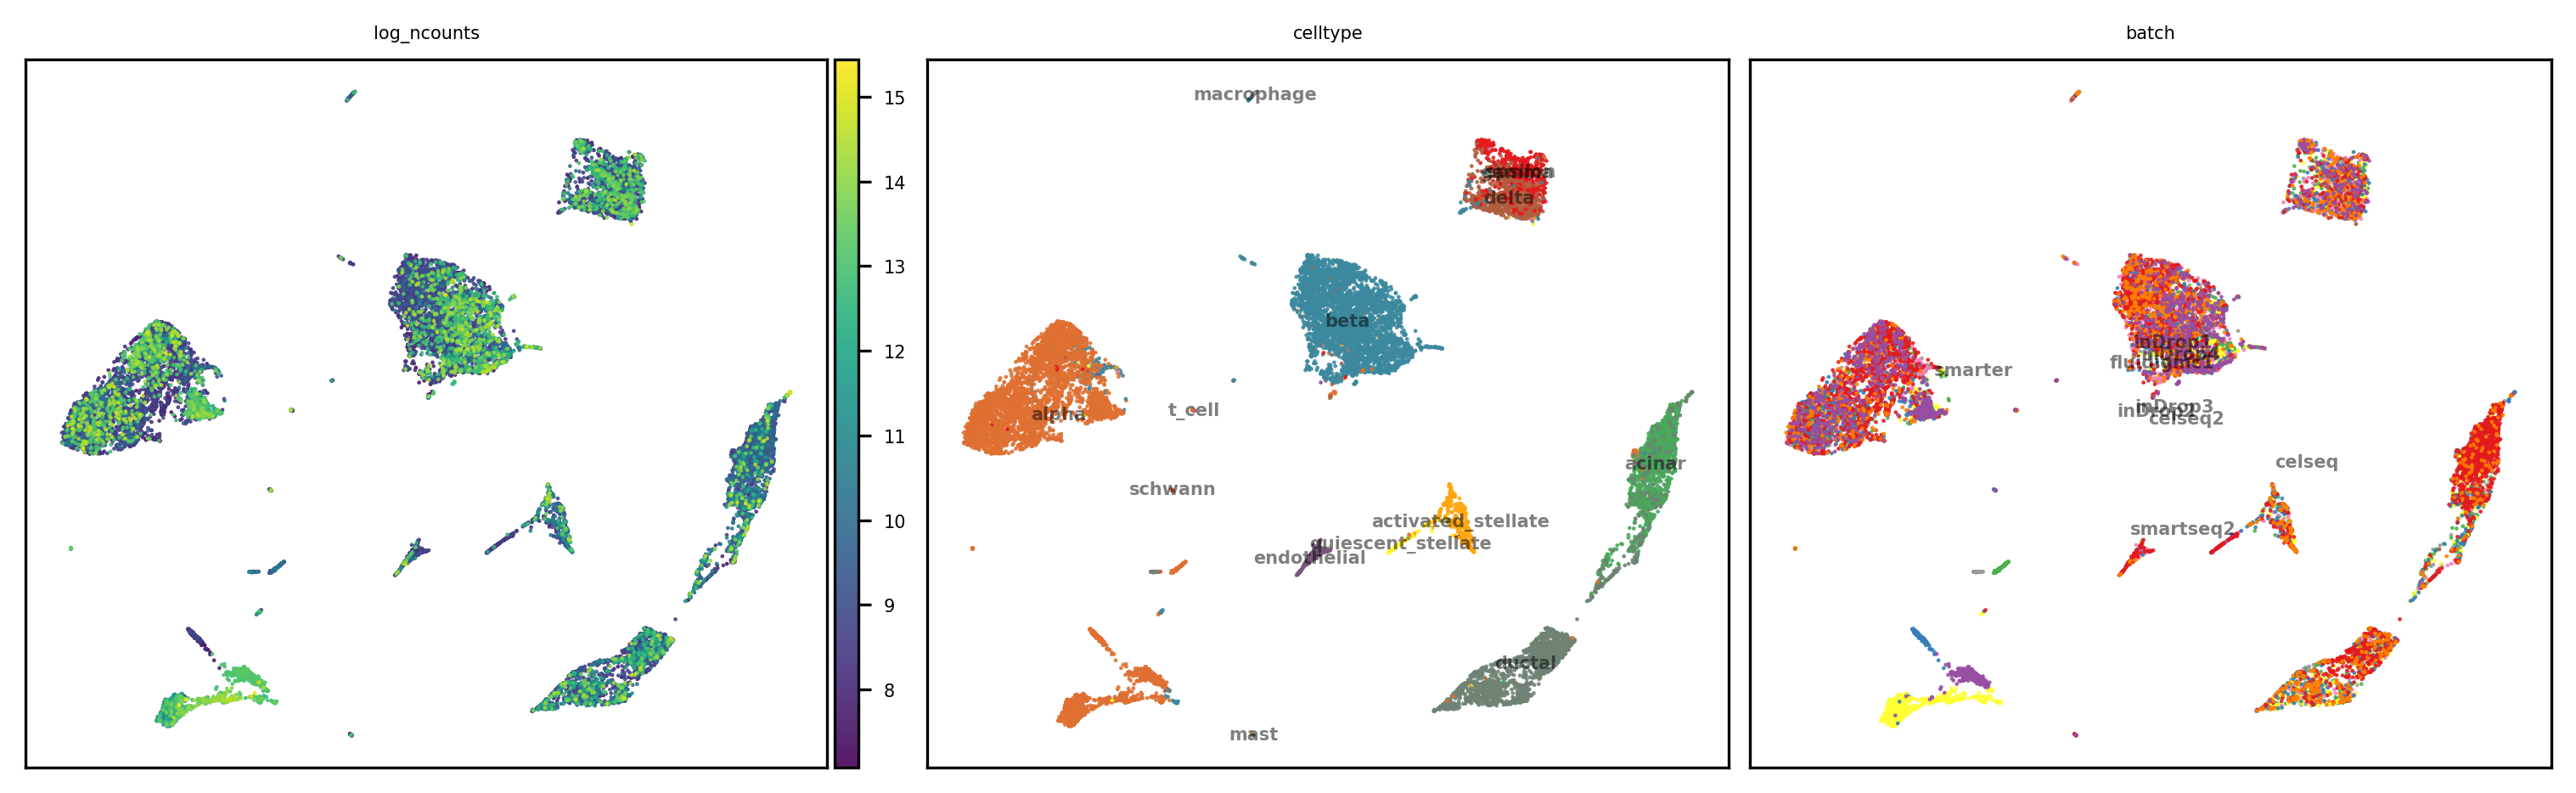

In [43]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Harmony

In [46]:
output_key = 'Harmony'
with timer:
    ccd.ul.run_harmony(adata, batch_key="batch", input_key='X_pca', output_key=output_key)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


Concord - INFO - UMAP embedding stored in adata.obsm['Harmony_UMAP']


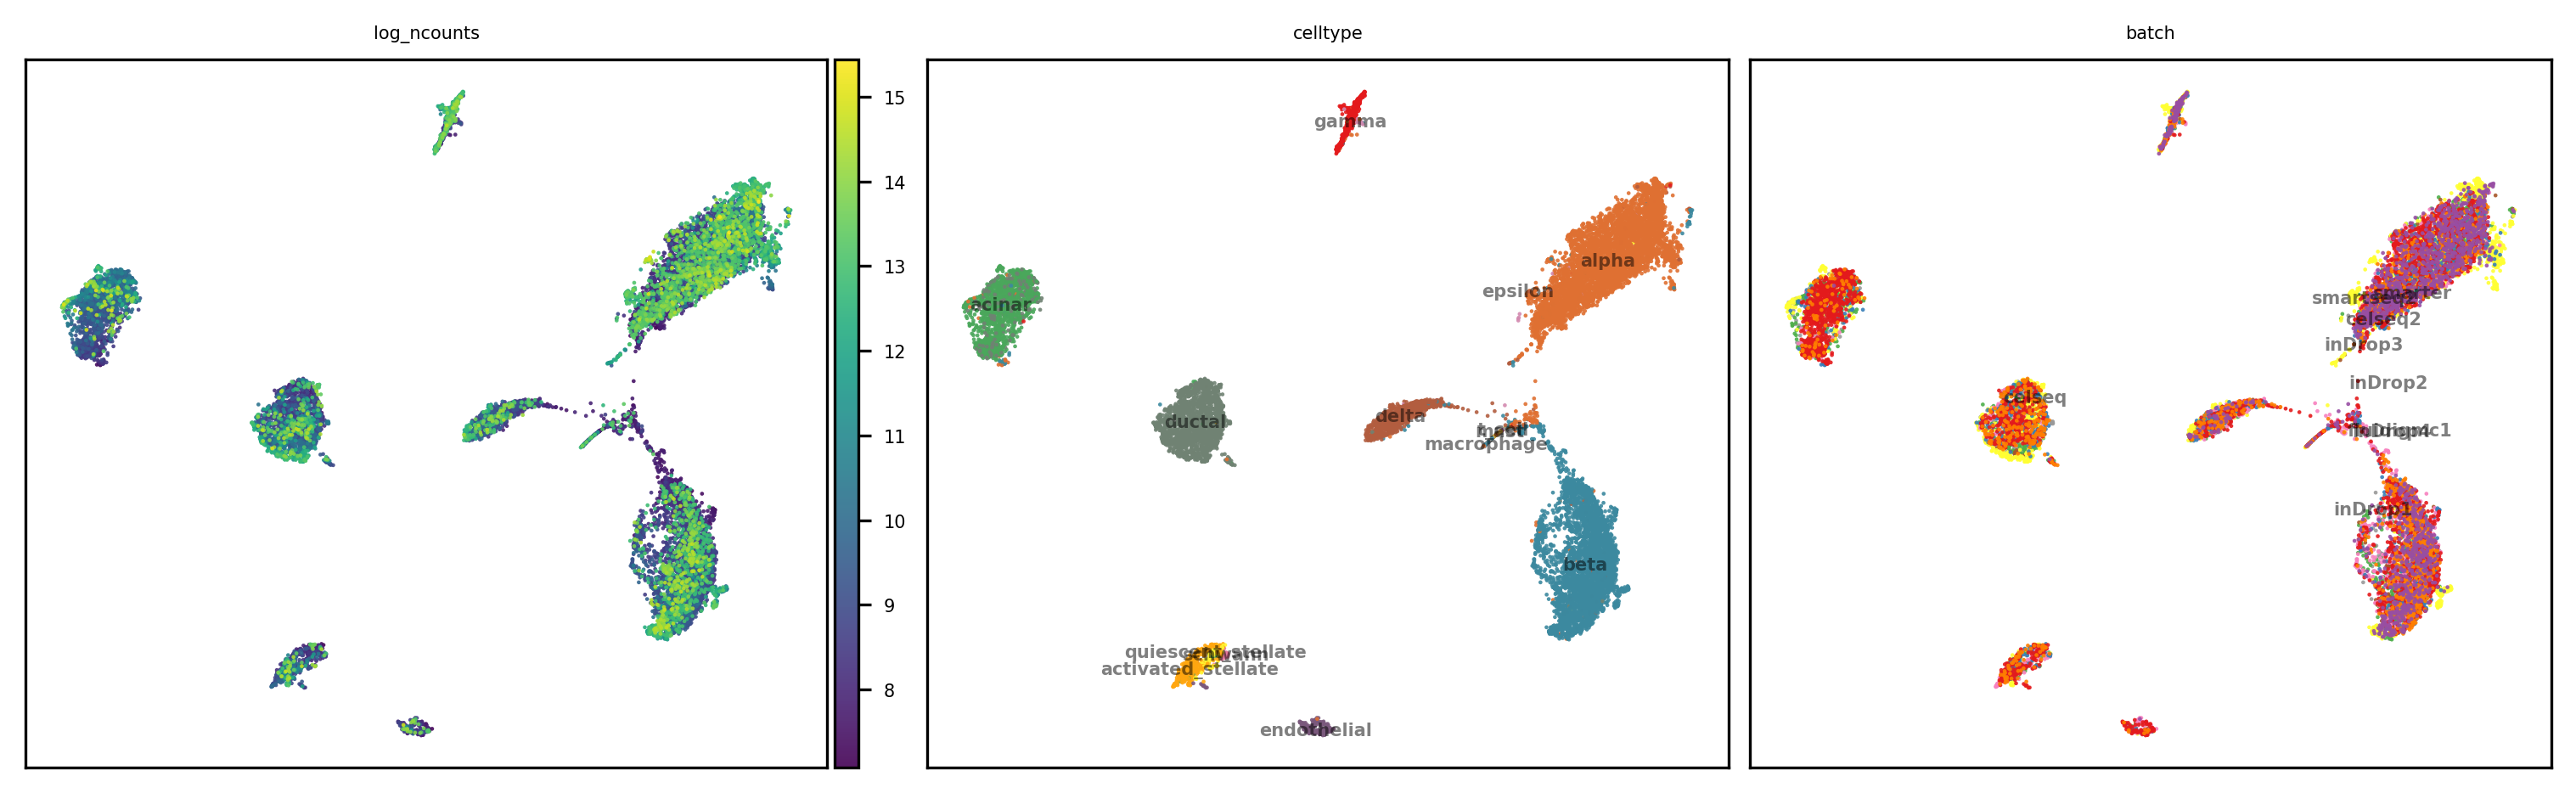

In [47]:
output_key = 'Harmony'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scVI

In [71]:
output_key = 'scVI'
import scvi
scvi.settings.device = device
with timer:
    scvi_vae = ccd.ul.run_scvi(adata, batch_key="batch", output_key=output_key, return_model=True, return_corrected=False, transform_batch=None)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_

Epoch 37/400:   9%|▉         | 36/400 [00:56<09:33,  1.57s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.67e+3]

Epoch 400/400: 100%|██████████| 400/400 [10:45<00:00,  1.68s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.59e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:45<00:00,  1.61s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.59e+3]


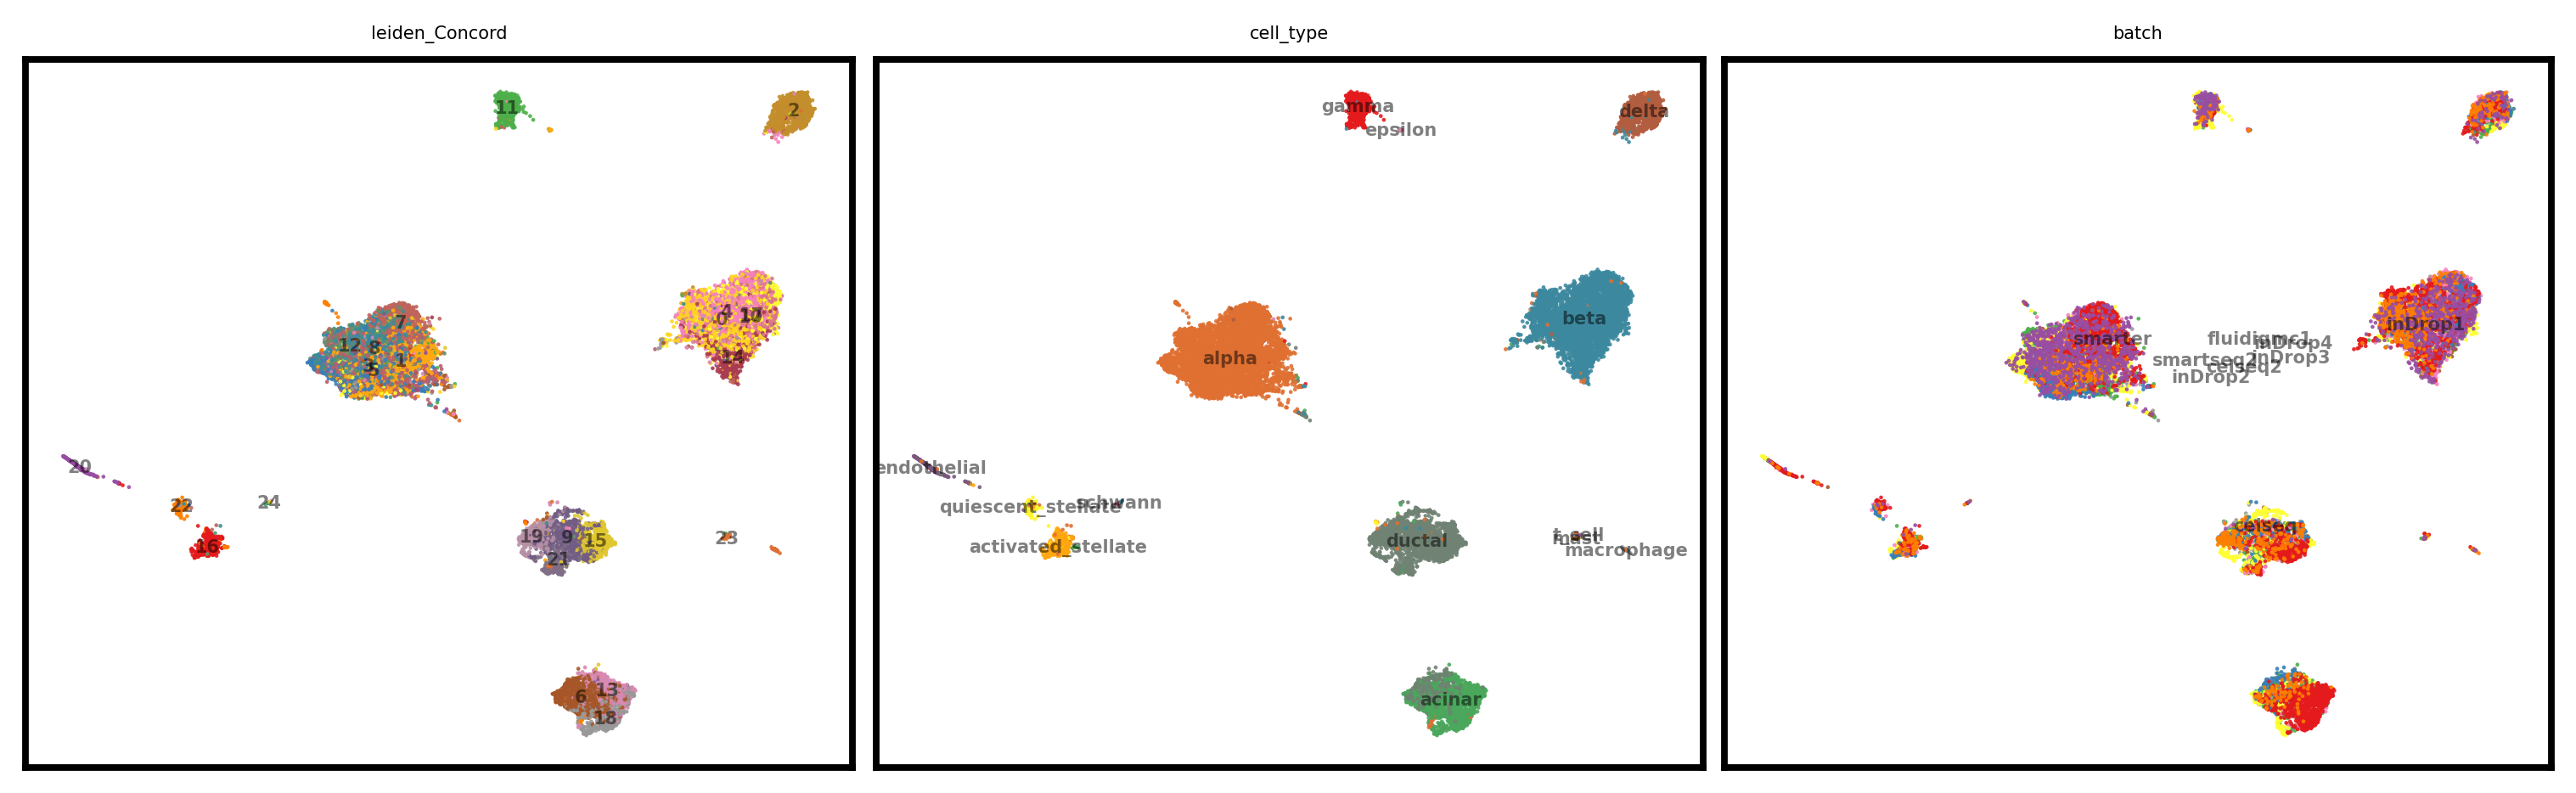

In [72]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'scVI'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scANVI

In [50]:
output_key = 'scANVI'
with timer:
    ccd.ul.run_scanvi(adata, batch_key="batch", labels_key='cell_type', output_key=output_key, scvi_model=scvi_vae, return_corrected=True, transform_batch=None)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

INFO     Training for 20 epochs.                                                                                   


INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_

Epoch 20/20: 100%|██████████| 20/20 [03:46<00:00, 11.49s/it, v_num=1, train_loss_step=5.21e+3, train_loss_epoch=6.48e+3]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:46<00:00, 11.30s/it, v_num=1, train_loss_step=5.21e+3, train_loss_epoch=6.48e+3]


Concord - INFO - UMAP embedding stored in adata.obsm['scANVI_UMAP']


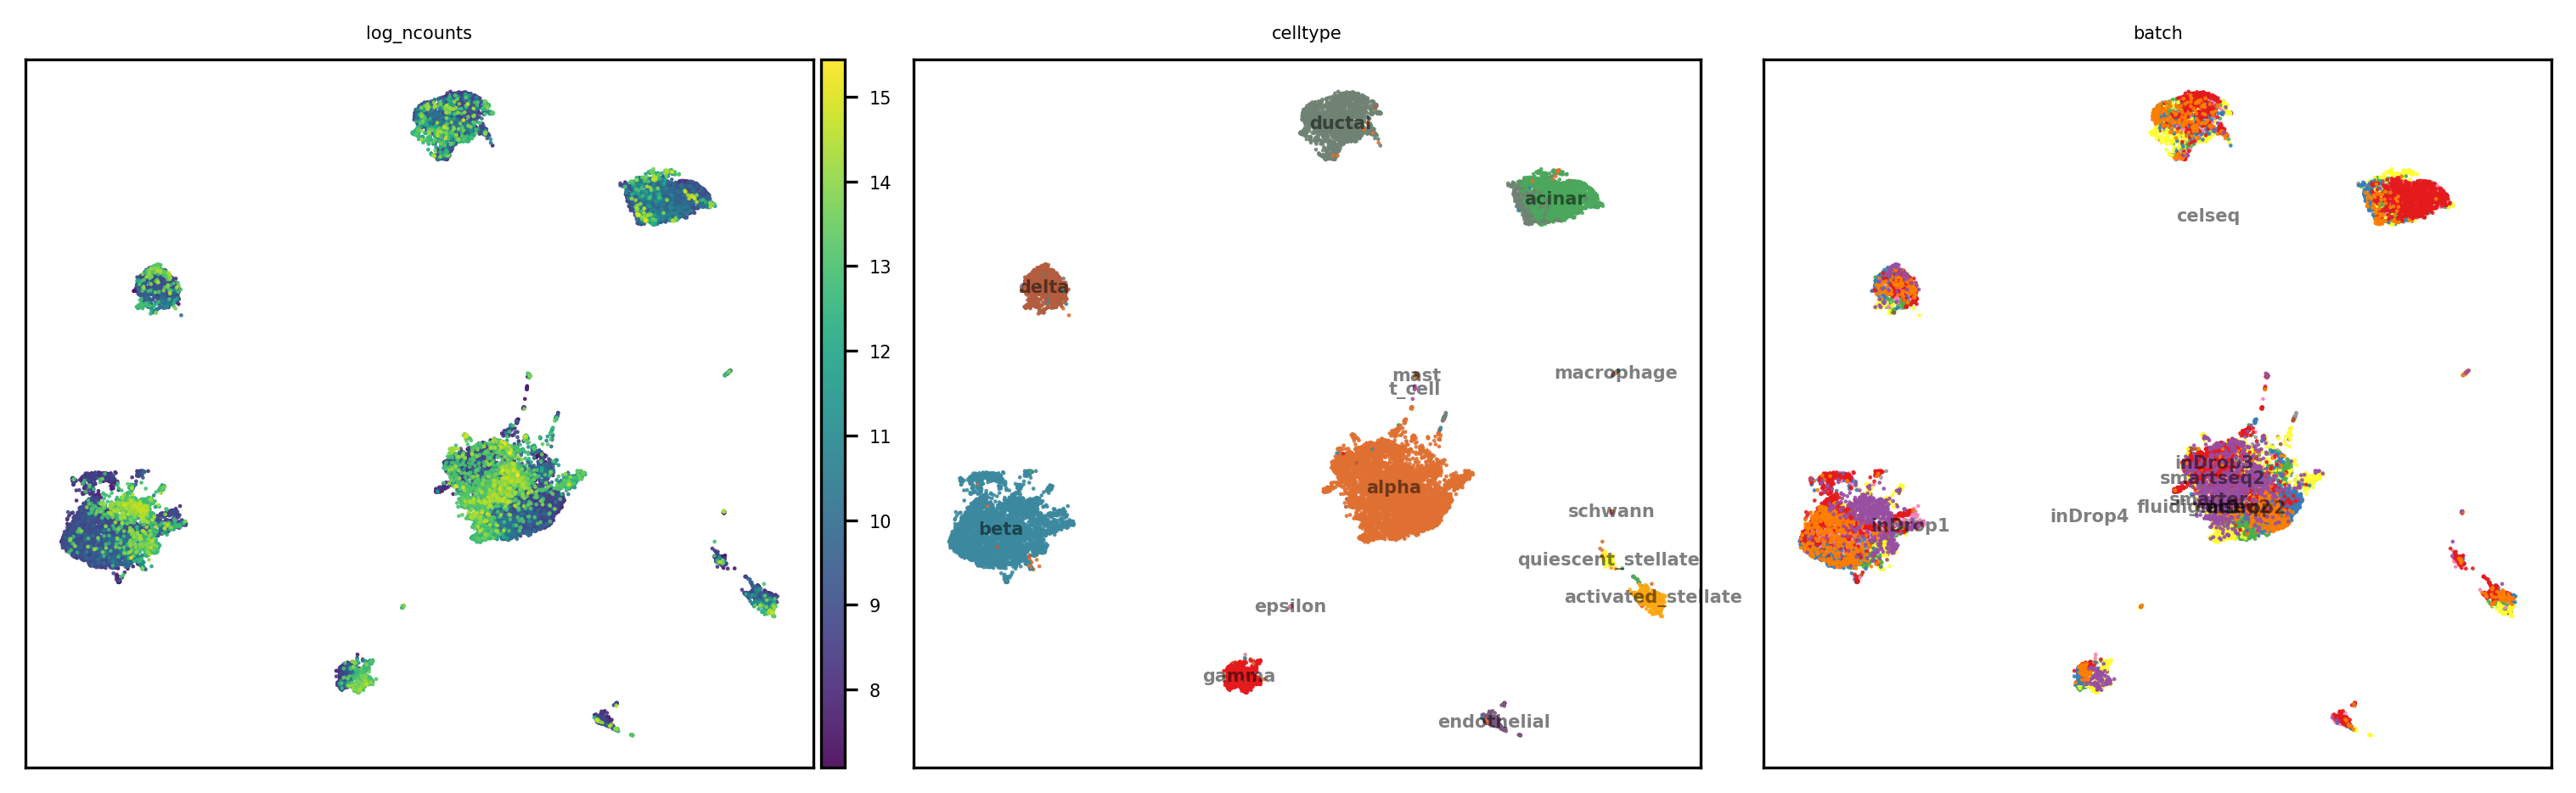

In [51]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'scANVI'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [52]:
adata.layers

Layers with keys: counts, log_normalized, normalized, Liger_corrected, scANVI_corrected

### Concord

In [20]:
adata.shape

(16382, 3000)

In [21]:
adata.obs['cell_type'].value_counts()

cell_type
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: count, dtype: int64

In [113]:
concord_args = {
    'adata': adata,
    'input_feature': None, 
    'min_p_intra_domain': 0.95,
    'n_epochs': 15,
    'p_intra_knn': 0.3,
    #'sampler_knn': 100,
    'augmentation_mask_prob': 0.4,
    'clr_temperature': 0.3,
    'latent_dim': 64,
    'domain_key': 'batch',
    'seed': seed, # random seed
    'verbose': False, # print training progress
    'device': device, # device to run on
    'save_dir': save_dir # directory to save model checkpoints
}


In [114]:
cur_ccd = ccd.Concord( use_decoder=False, **concord_args)

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
with timer:
    cur_ccd.encode_adata(input_layer_key='X_log1p', preprocess=True, output_key=output_key)

time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:03, 78.87it/s, loss=3.27]
Epoch 14 Training: 100%|██████████| 251/251 [00:04<00:00, 60.45it/s, loss=2.7] 


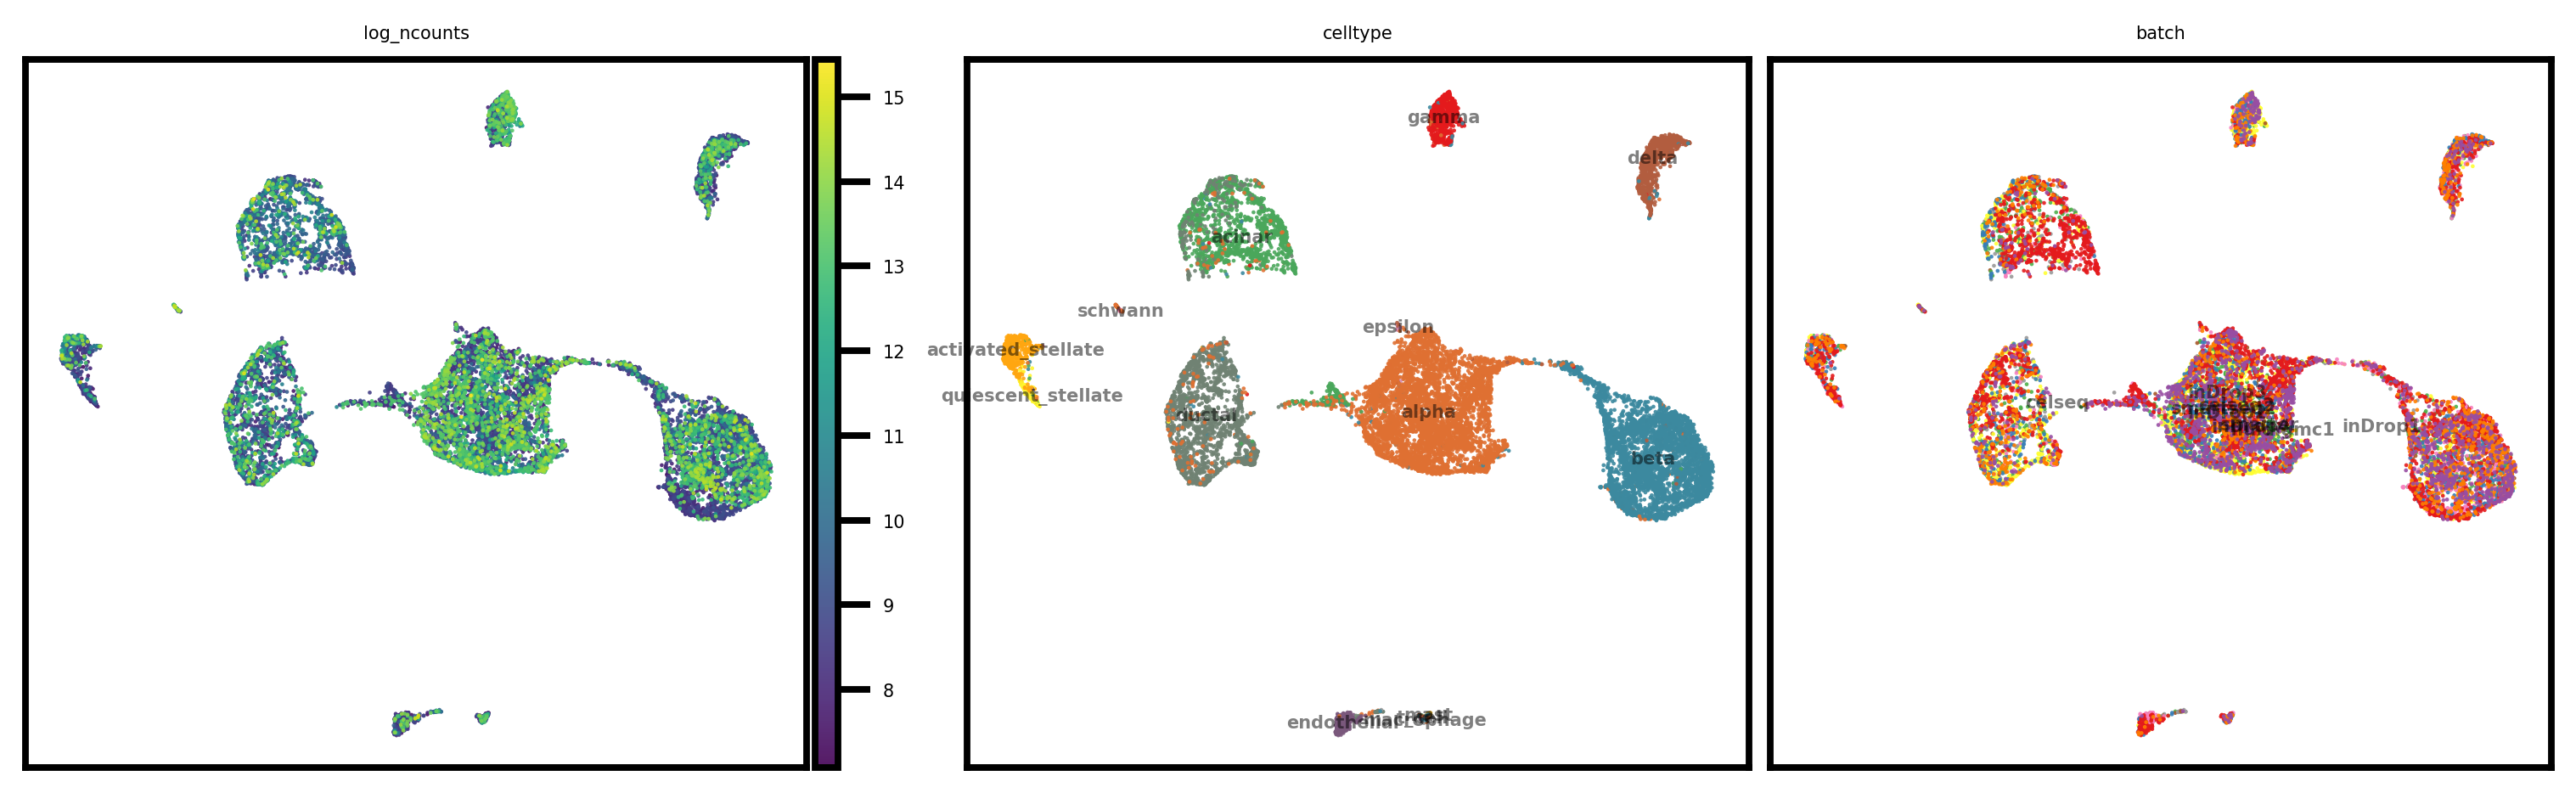

In [115]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'Concord'
show_cols = ['log_ncounts', 'celltype', 'batch']
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

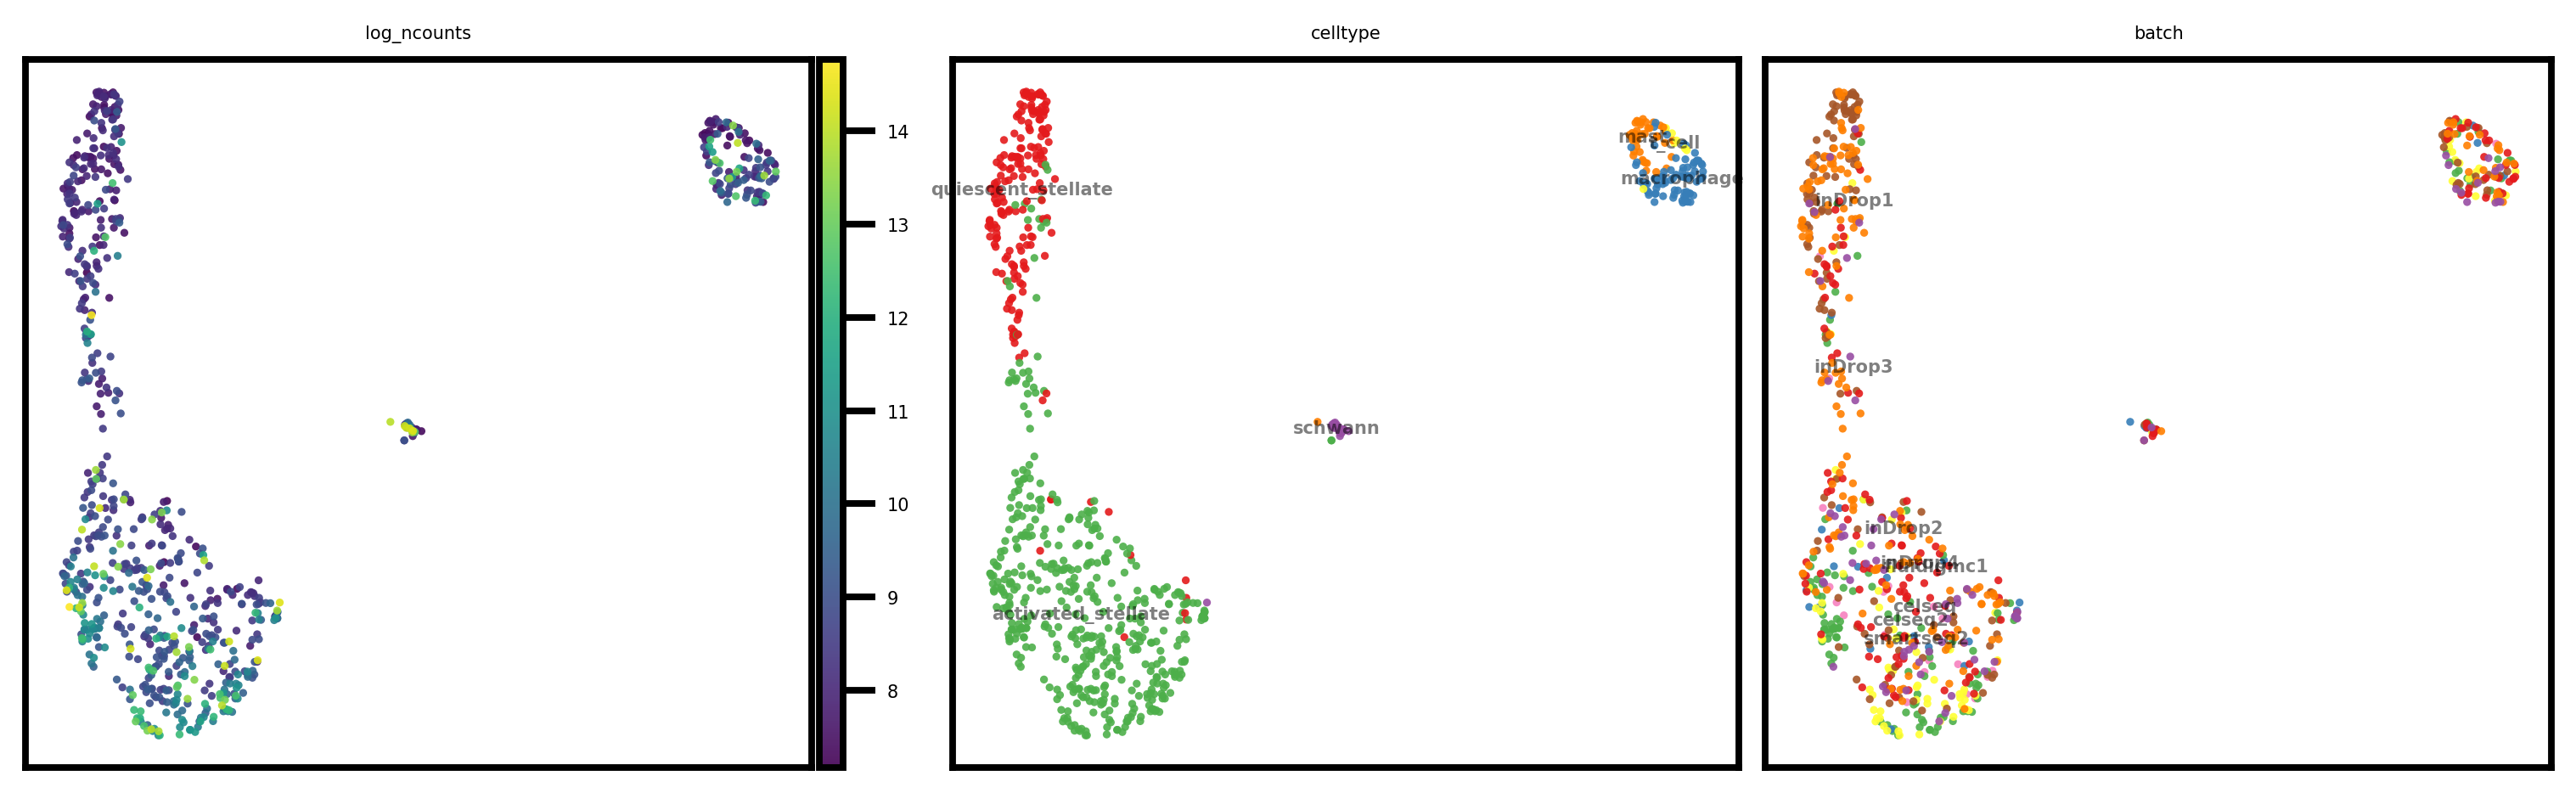

In [116]:
output_key = 'Concord'
adata_sub = adata[adata.obs['cell_type'].isin(['activated_stellate', 'quiescent_stellate', 'schwann', 'macrophage', 'mast', 't_cell'])]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"embeddings_sub_{show_basis}_{file_suffix}.png"
)

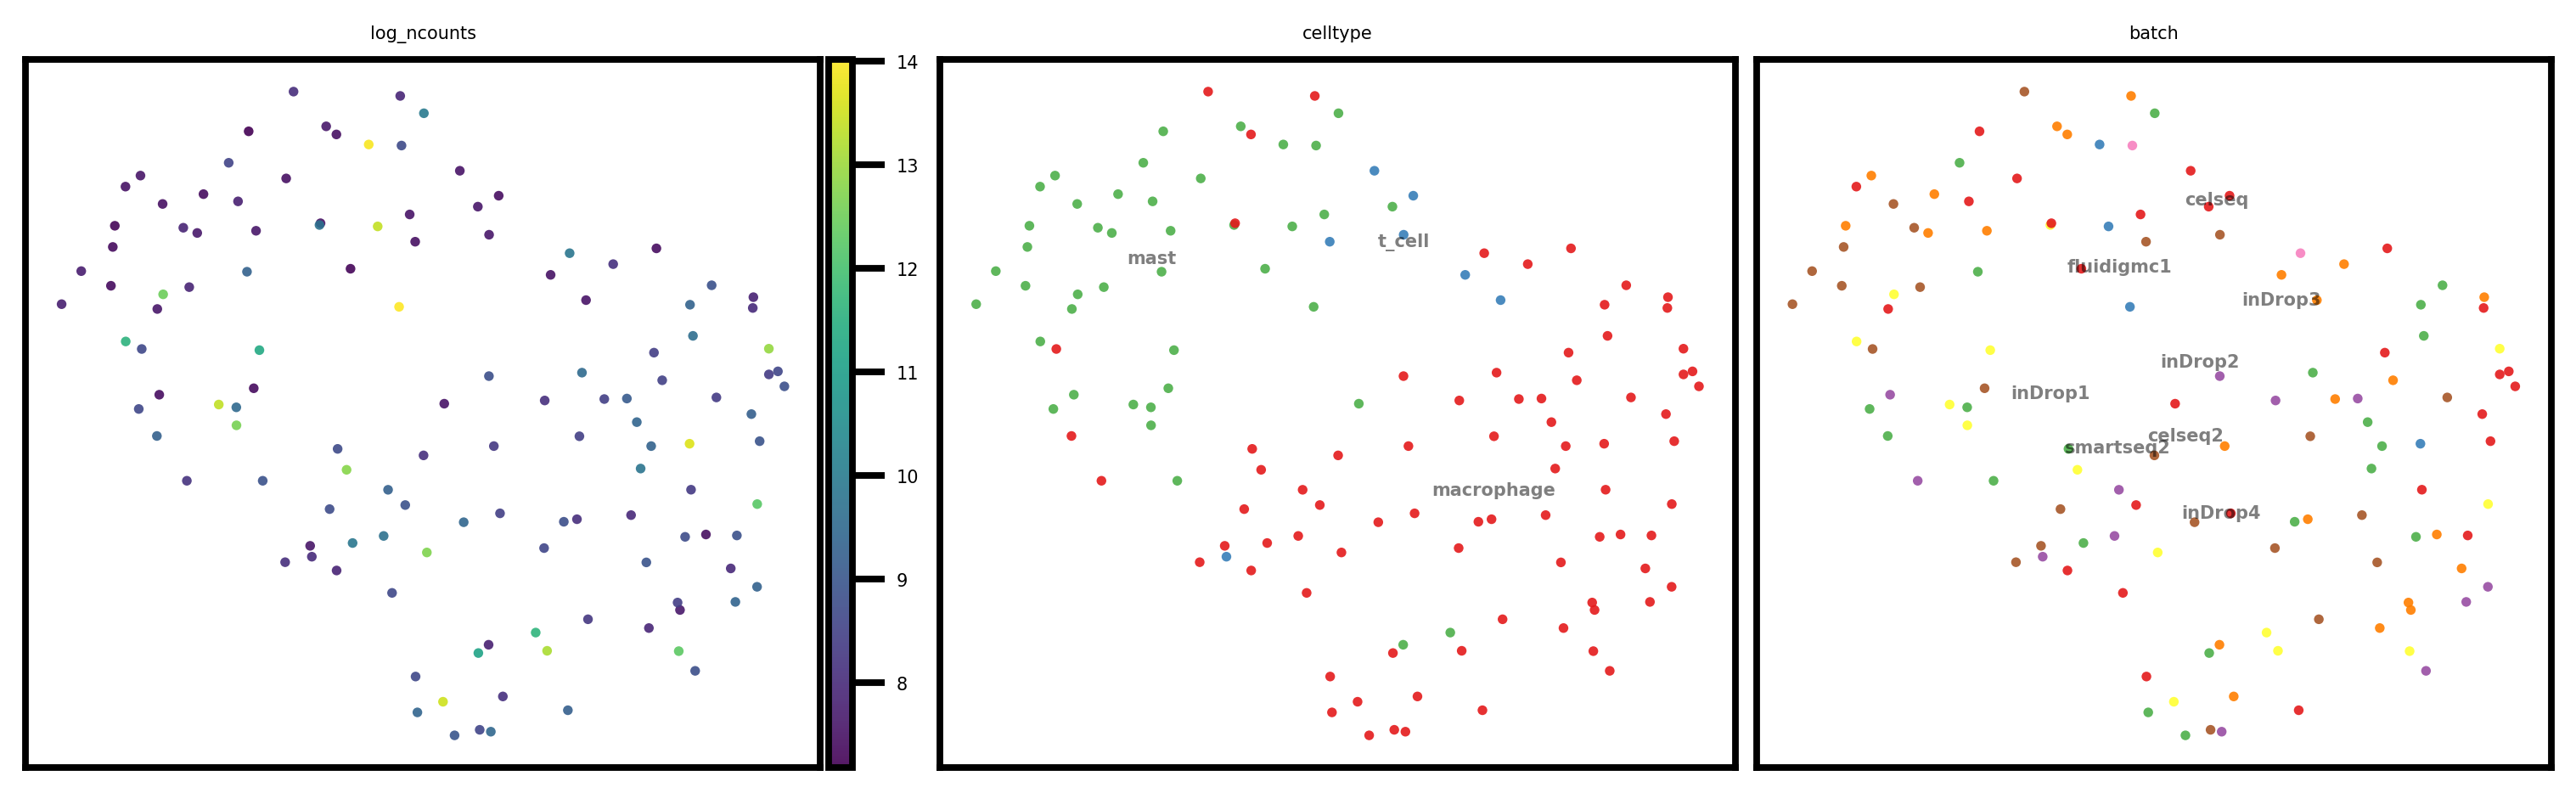

In [117]:
output_key = 'Concord'
adata_sub = adata[adata.obs['cell_type'].isin(['macrophage', 'mast', 't_cell'])]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=30, legend_loc='on data',
    save_path=save_dir / f"embeddings_sub_{show_basis}_{file_suffix}.png"
)

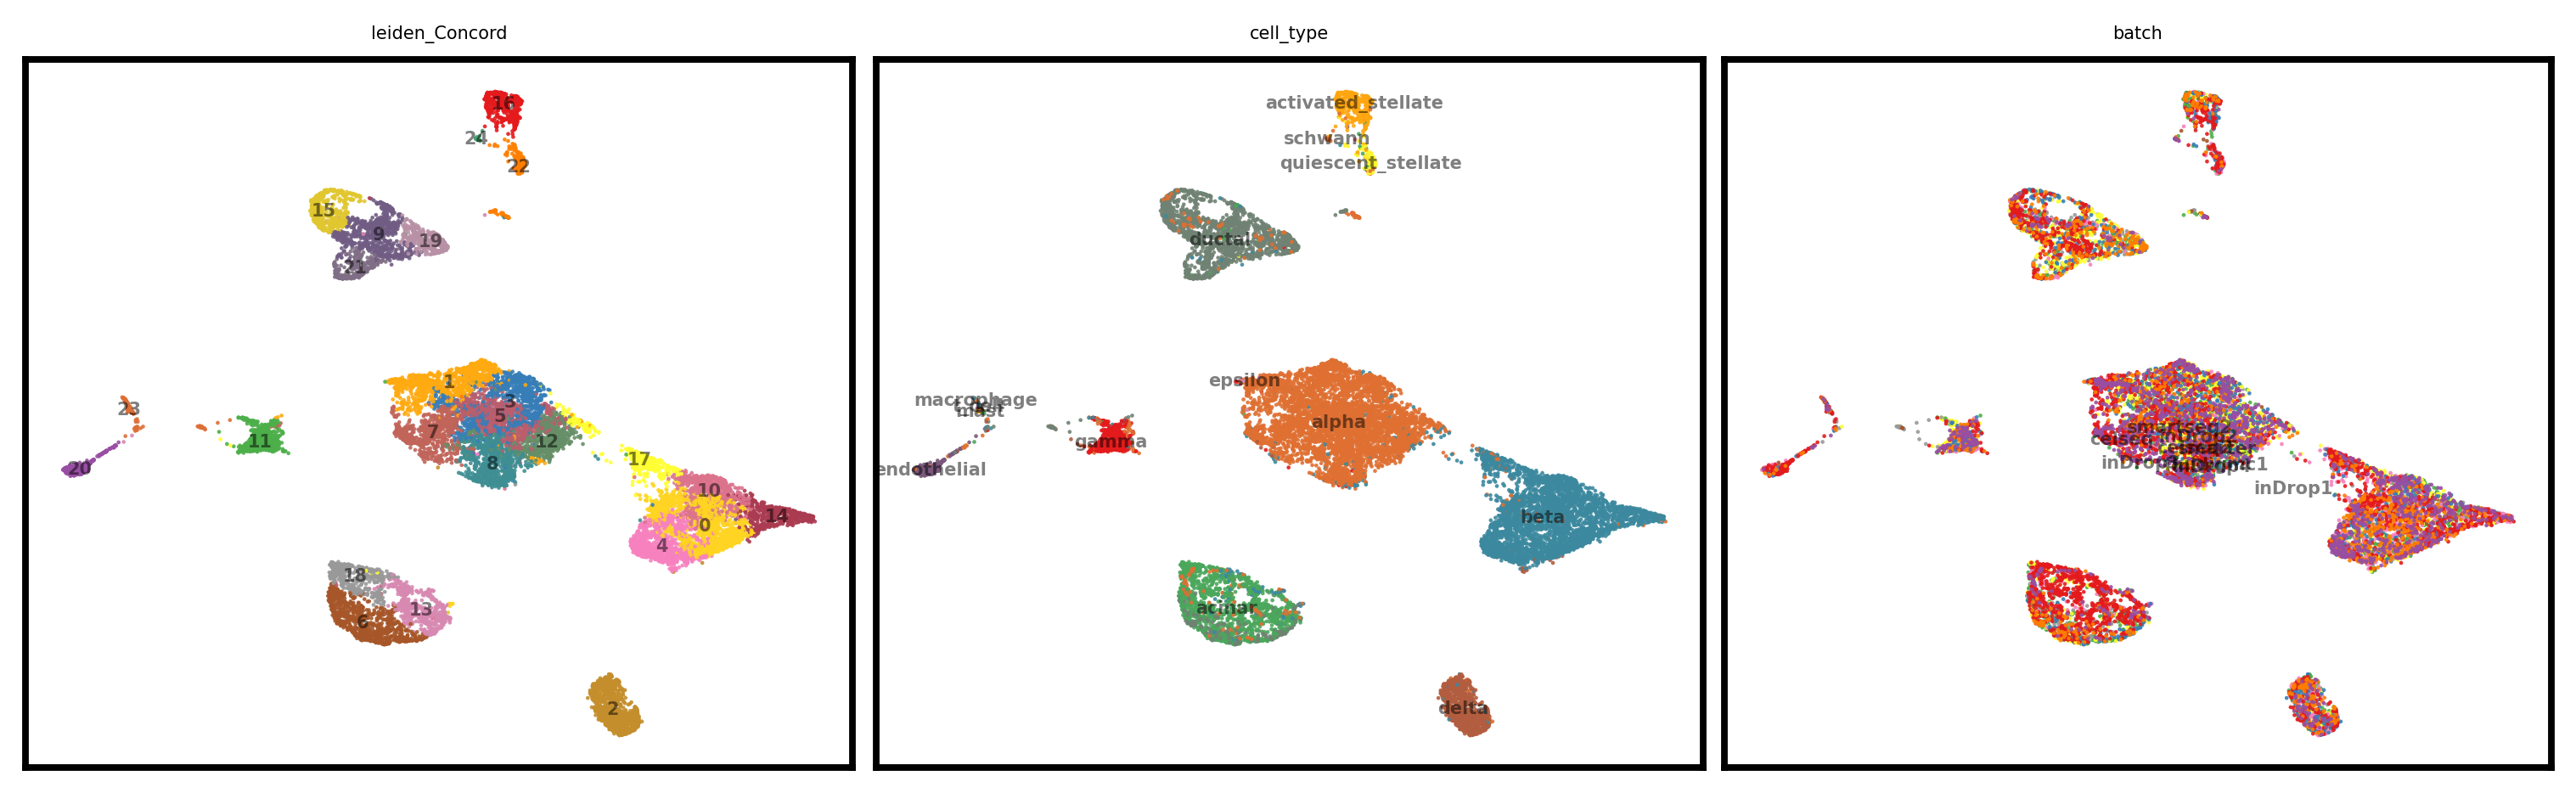

isolated labels: no more than 4 batches per label
t_cell: 0.42418377101421356
isolated labels: no more than 4 batches per label
Compute neighbors on rep Concord


t_cell: 0.0880503144654088
NMI: 0.625, ARI: 0.279, isolated_labels_asw: 0.424, isolated_labels_f1: 0.088, silhouette: 0.527


In [ ]:
import scib
output_key = 'Concord'
cluster_key = f'leiden_{output_key}'
label_key = 'cell_type'
sc.pp.neighbors(adata, n_neighbors=30, use_rep=output_key, metric='euclidean')
sc.tl.leiden(adata, resolution=1.0, key_added=cluster_key)
show_basis = f'{output_key}_UMAP'
show_cols = [cluster_key, label_key, 'batch']
nmi_val = scib.metrics.nmi(adata, cluster_key, label_key)
ari_val = scib.metrics.ari(adata, cluster_key, label_key)
print(f"NMI: {nmi_val:.3f}, ARI: {ari_val:.3f}, isolated_labels_asw: {label_asw:.3f}, isolated_labels_f1: {label_f1:.3f}, silhouette: {silhouette:.3f}")

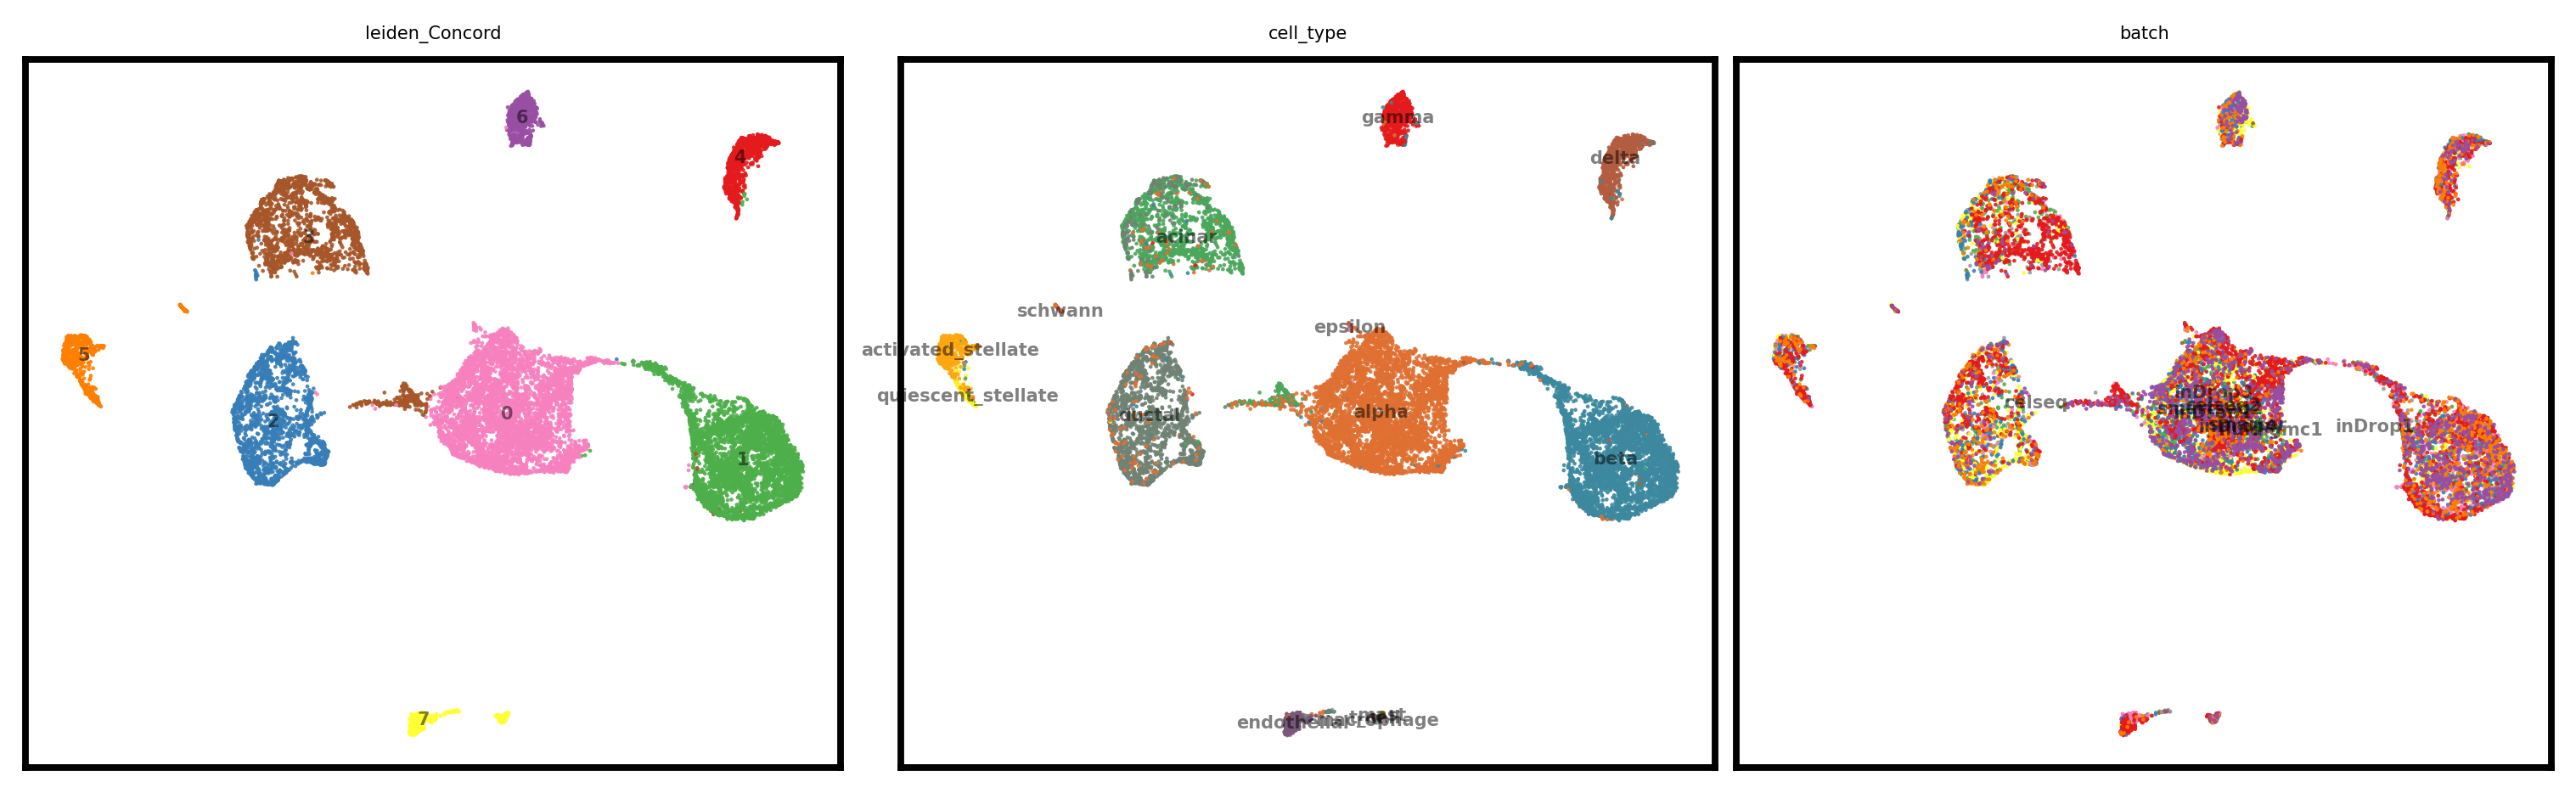

NMI: 0.851, ARI: 0.888, silhouette: 0.579


In [118]:
import scib
output_key = 'Concord'
cluster_key = f'leiden_{output_key}'
label_key = 'cell_type'
sc.pp.neighbors(adata, n_neighbors=30, use_rep=output_key, metric='euclidean')
sc.tl.leiden(adata, resolution=0.2, key_added=cluster_key)
show_basis = f'{output_key}_UMAP'
show_cols = [cluster_key, label_key, 'batch']

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_leiden_{show_basis}_{file_suffix}.png"
)
nmi_val = scib.metrics.nmi(adata, cluster_key, label_key)
ari_val = scib.metrics.ari(adata, cluster_key, label_key)
silhouette = scib.me.silhouette(adata, label_key=label_key, embed=output_key)
print(f"NMI: {nmi_val:.3f}, ARI: {ari_val:.3f}, silhouette: {silhouette:.3f}")

### Concord-decoder

In [119]:
decoder_ccd = ccd.Concord(use_decoder=True, **concord_args)

output_key = 'Concord-decoder'
with timer:
    decoder_ccd.encode_adata(input_layer_key='X_log1p', preprocess=True, output_key=output_key)

time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(decoder_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:03, 65.54it/s, loss=3.76]
Epoch 14 Training: 100%|██████████| 251/251 [00:03<00:00, 67.61it/s, loss=3.22]


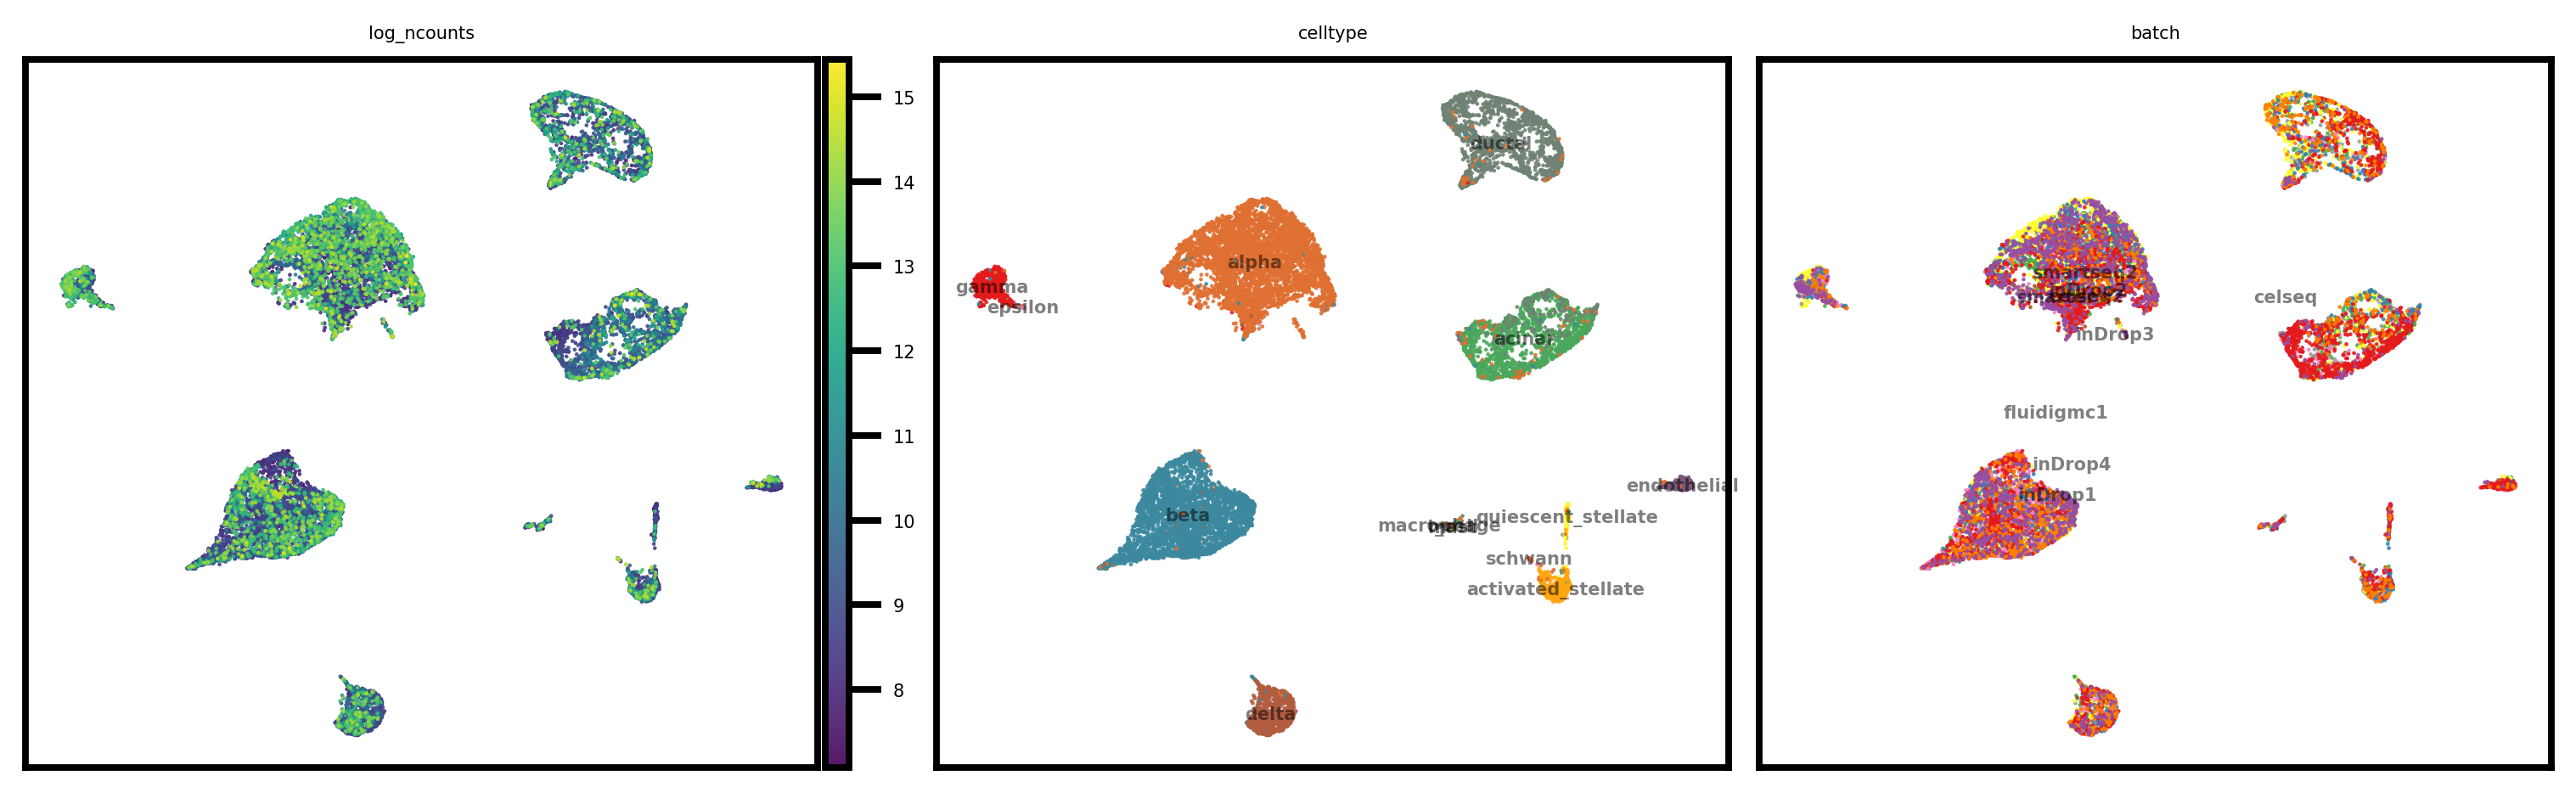

In [120]:
output_key = 'Concord-decoder'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

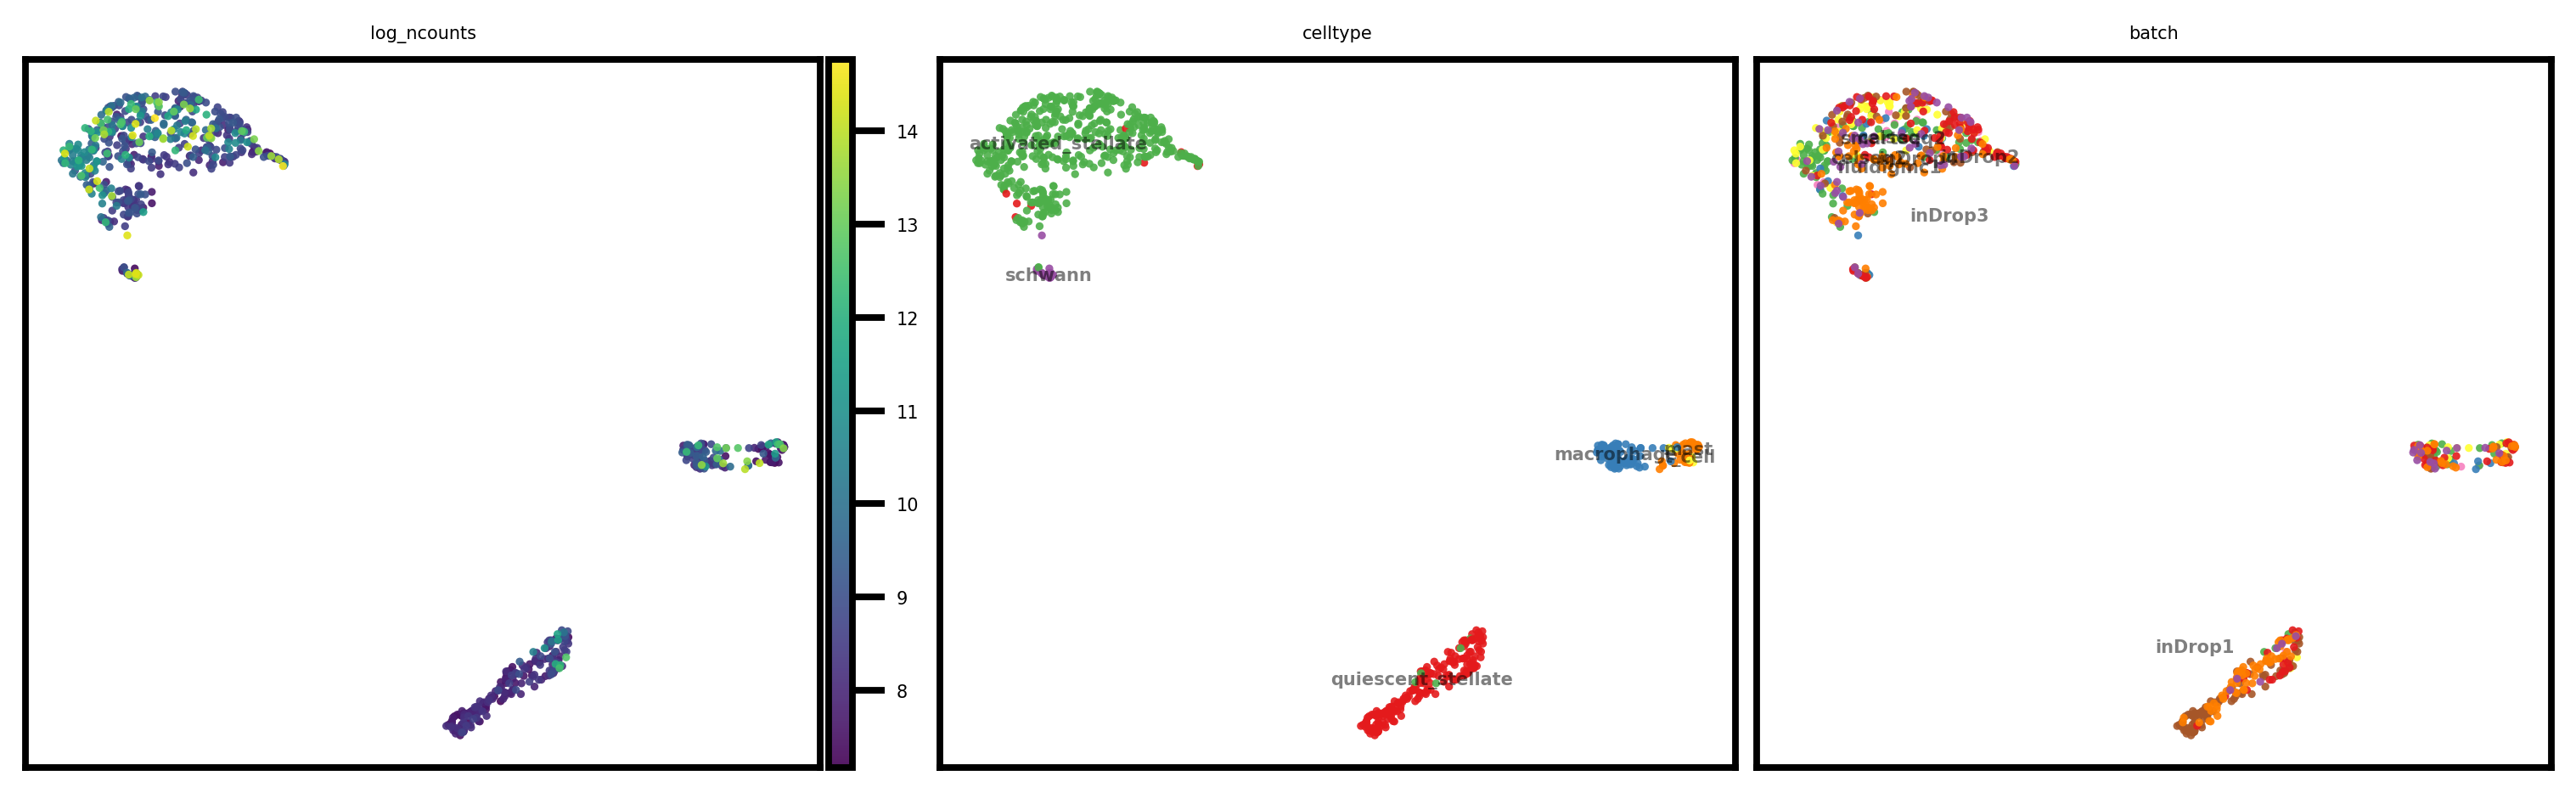

In [121]:
output_key = 'Concord-decoder'
adata_sub = adata[adata.obs['cell_type'].isin(['activated_stellate', 'quiescent_stellate', 'schwann', 'macrophage', 'mast', 't_cell'])]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"embeddings_sub_{show_basis}_{file_suffix}.png"
)

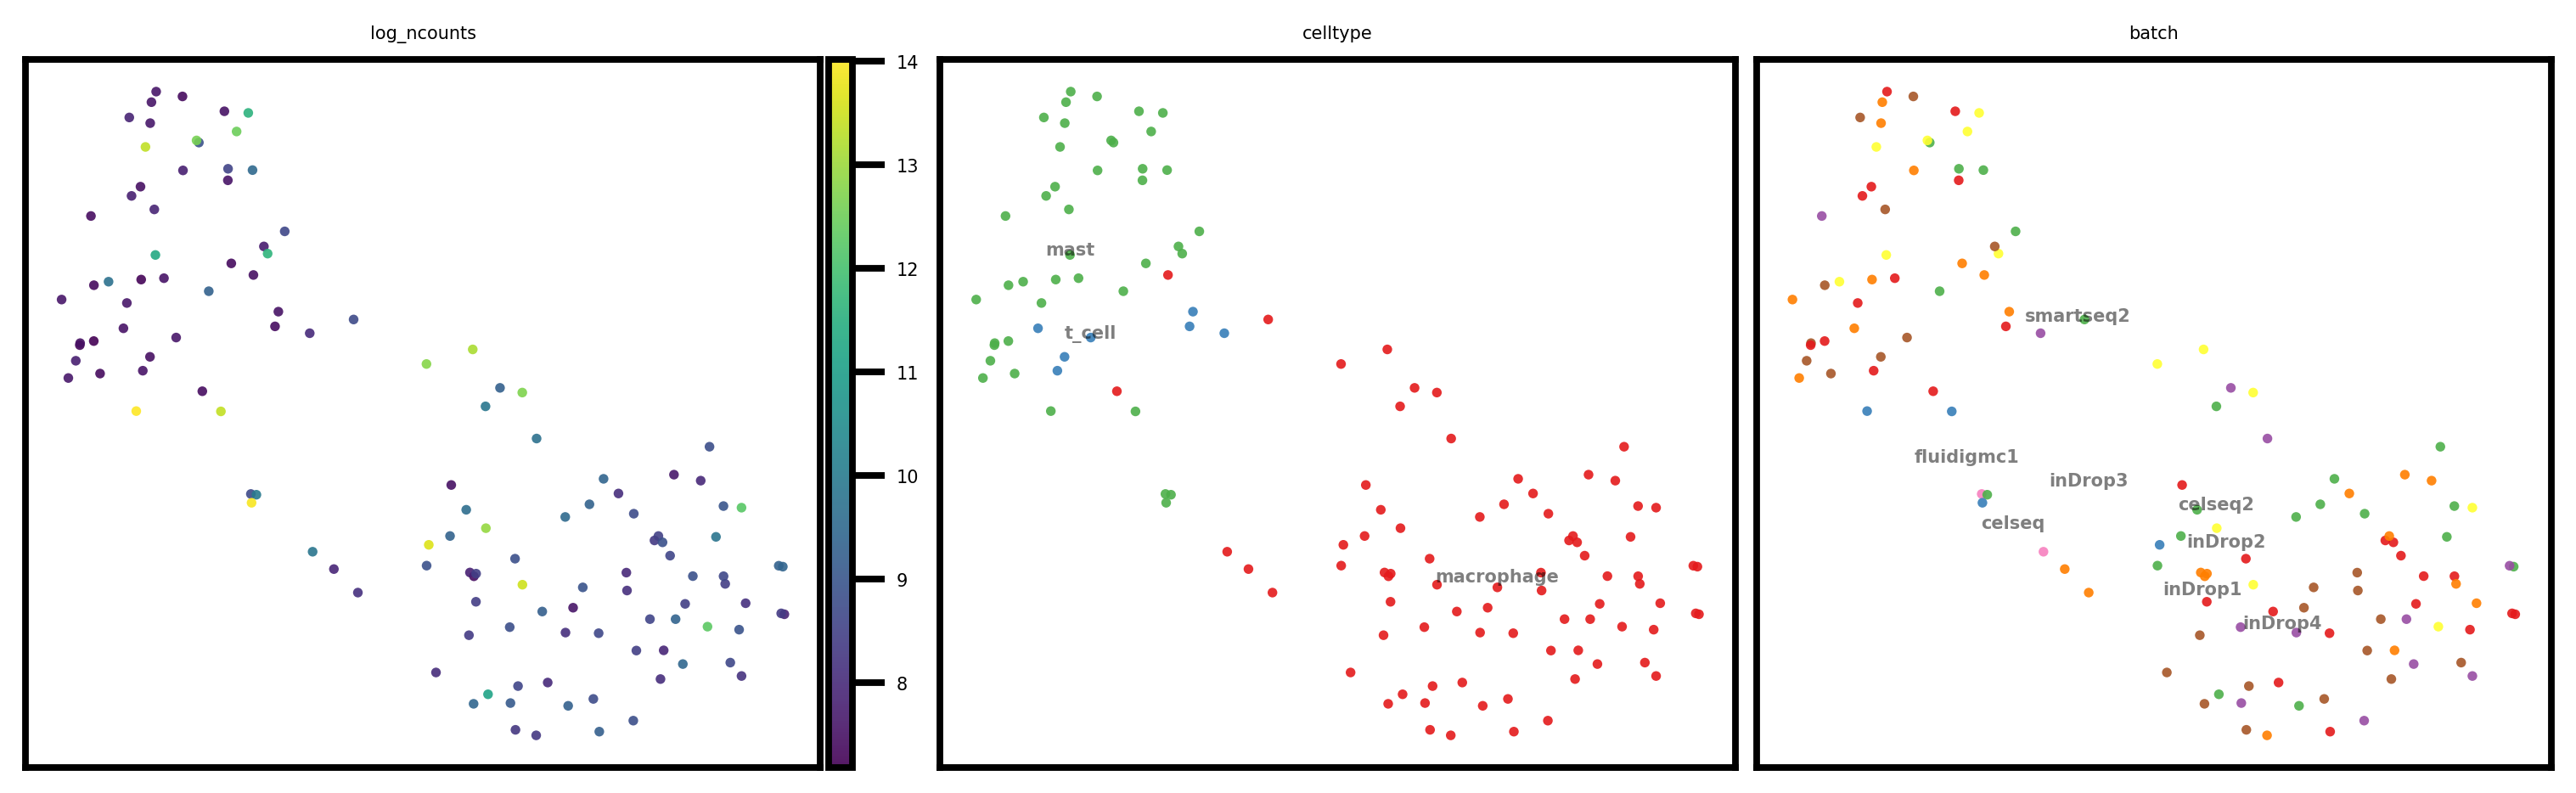

In [122]:
adata_sub = adata[adata.obs['cell_type'].isin(['macrophage', 'mast', 't_cell'])]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=30, legend_loc='on data',
    save_path=save_dir / f"embeddings_sub_{show_basis}_{file_suffix}.png"
)

### Concord-class

In [123]:
cur_ccd = ccd.Concord(use_classifier=True, # use classifier
                      class_key = 'cell_type', # key indicating cell type
                      train_frac=1.0, # fraction of data to use for training
                      **concord_args
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
output_key = 'Concord-class'
with timer:
    cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key, preprocess=True)

time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:03, 69.04it/s, loss=4.24]
Epoch 14 Training: 100%|██████████| 251/251 [00:04<00:00, 50.24it/s, loss=3.57]


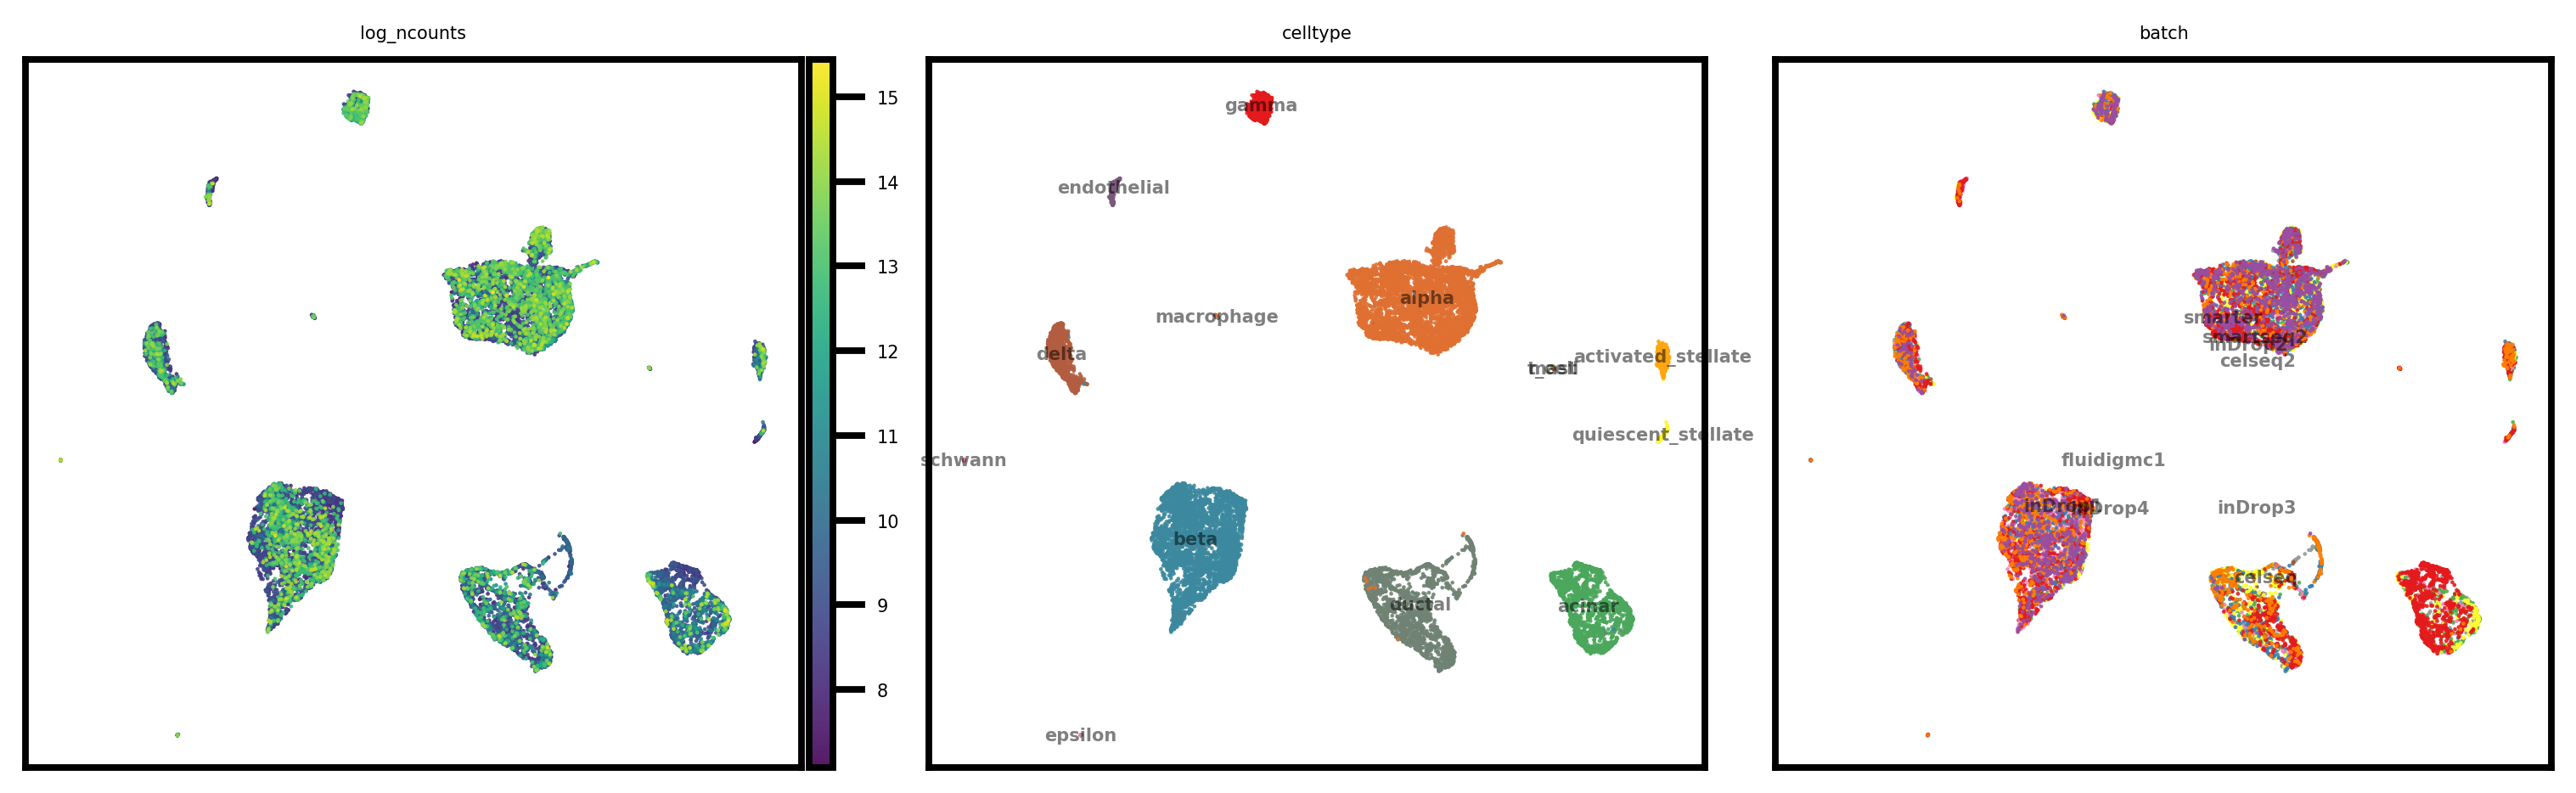

In [124]:
output_key = 'Concord-class'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

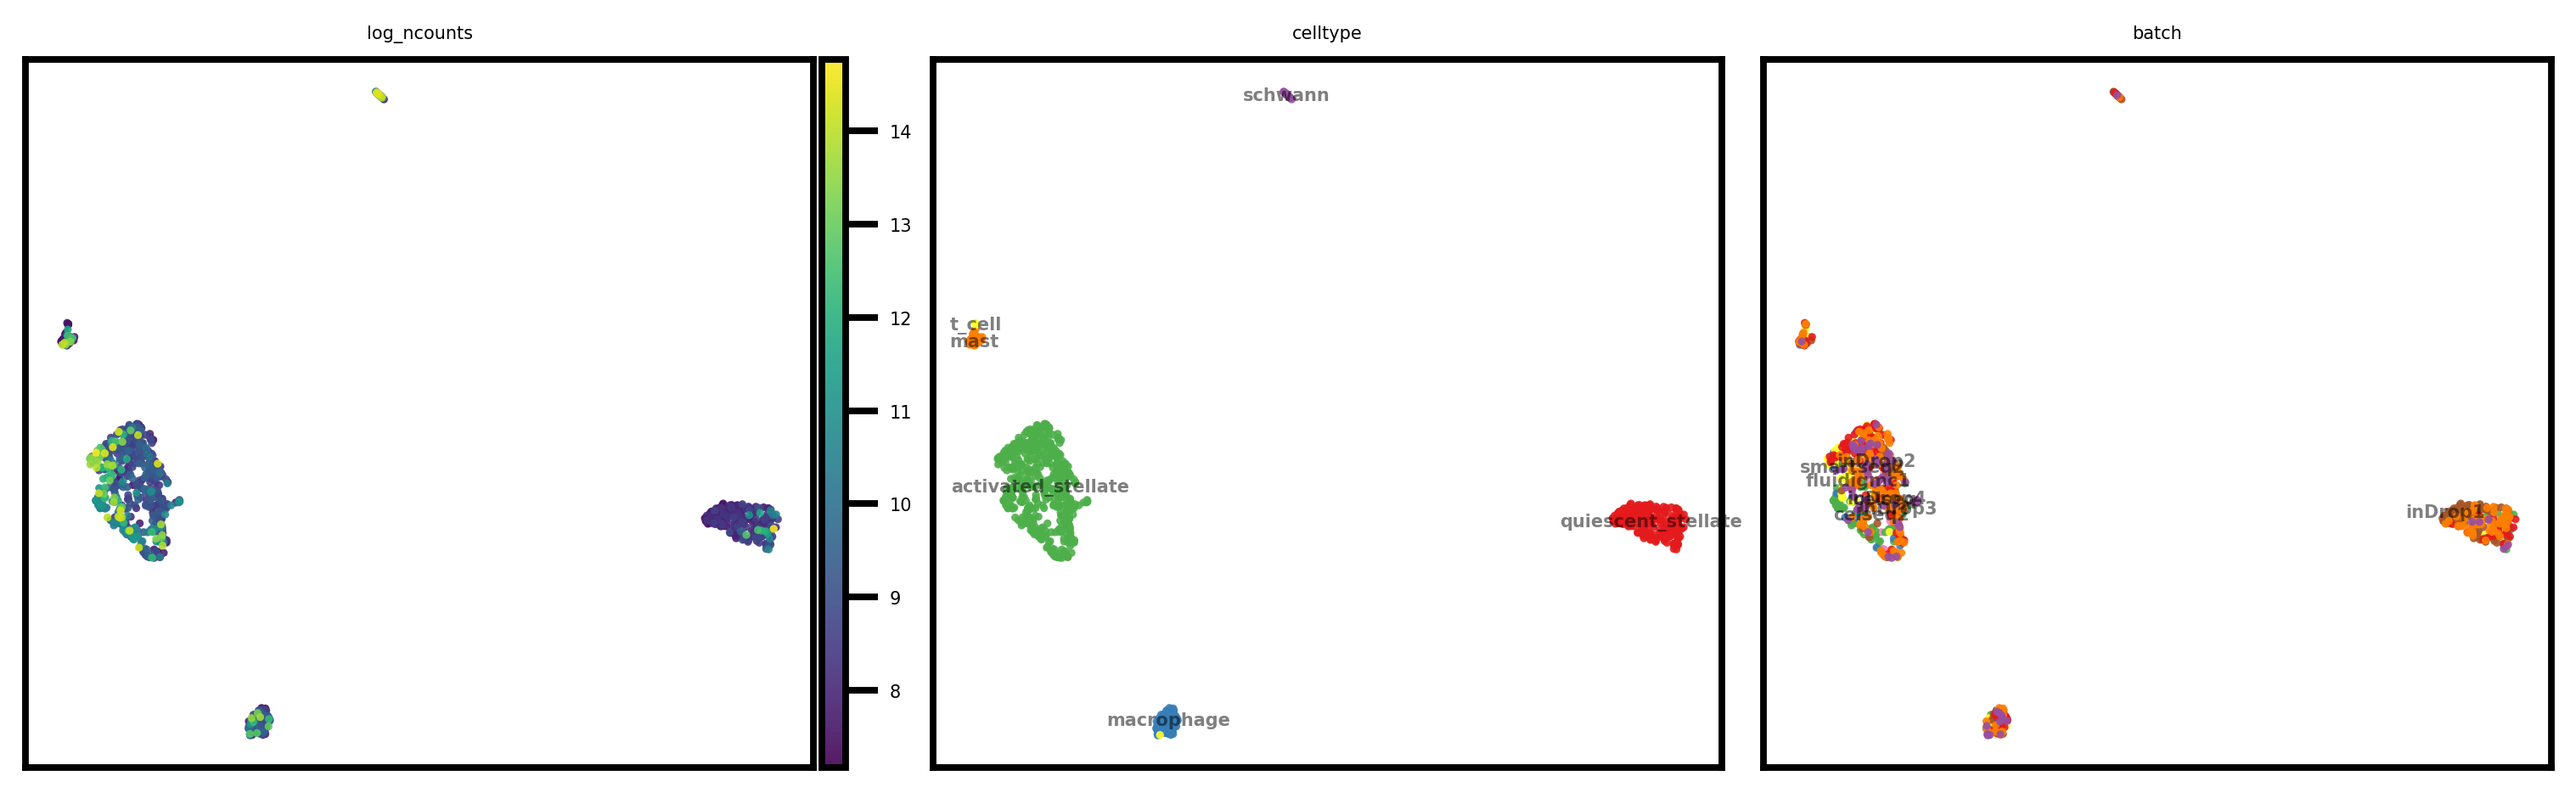

In [127]:
output_key = 'Concord-class'
adata_sub = adata[adata.obs['cell_type'].isin(['activated_stellate', 'quiescent_stellate', 'schwann', 'macrophage', 'mast', 't_cell'])]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"embeddings_sub_{show_basis}_{file_suffix}.png"
)

In [126]:
obsm_filename = save_dir / f"obsm_{file_suffix}.h5"
ccd.ul.save_obsm_to_hdf5(adata, obsm_filename)
adata.write_h5ad( data_dir / f"adata_{file_suffix}.h5ad")
file_suffix

'human_pancreas_benchmarking_Dec11-1918'

## Benchmarking

In [148]:
latent_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI", "Concord", 'Concord-decoder', "Concord-class"]
#latent_keys = ["Unintegrated", "Concord", 'Concord-decoder', "Concord-class"]

In [131]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key='batch',
    label_key='cell_type',
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  11%|█         | 1/9 [01:08<09:07, 68.38s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  22%|██▏       | 2/9 [02:37<09:24, 80.61s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  33%|███▎      | 3/9 [02:59<05:23, 53.84s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  44%|████▍     | 4/9 [03:52<04:27, 53.47s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  56%|█████▌    | 5/9 [04:12<02:45, 41.39s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  67%|██████▋   | 6/9 [04:29<01:39, 33.19s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  78%|███████▊  | 7/9 [05:34<01:26, 43.38s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  89%|████████▉ | 8/9 [06:36<00:49, 49.38s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings: 100%|██████████| 9/9 [07:44<00:00, 51.65s/it]


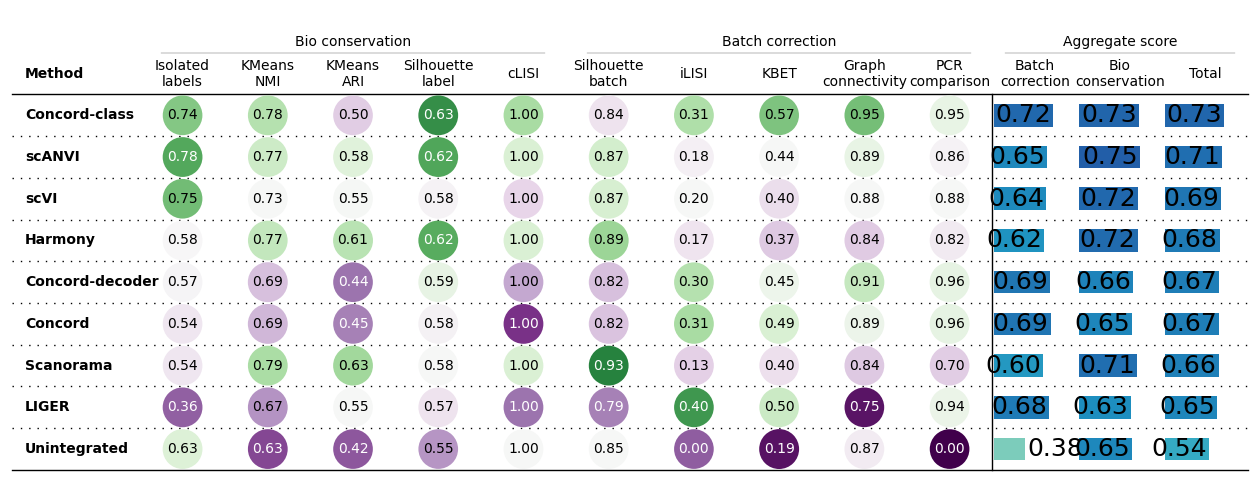

In [134]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(16, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [149]:
# Recompute nmi and ari using the approach described in paper, with resolution range from 0.1 to 1.0 step 0.1
label_key = 'cell_type'
nmi_df, ari_df = ccd.ul.benchmark_nmi_ari(adata, emb_keys=latent_keys, label_key=label_key, resolution_range=np.arange(0.1, 1.1, 0.1), n_neighbors=15, metric='euclidean', verbose=True)
nmi_df.to_csv(save_dir / f"nmi_{file_suffix}.csv")
ari_df.to_csv(save_dir / f"ari_{file_suffix}.csv")

In [174]:
import pandas as pd
scib_scores = bm.get_results(min_max_scale=False)
scib_scores.to_csv(save_dir / f"scib_scores_{file_suffix}.csv")
# Take the max across resolutions for nmi and ari
nmi_max = nmi_df.max()
ari_max = ari_df.max()
# Replace '('Bio conservation', 'KMeans NMI'), ('Bio conservation', 'KMeans ARI') in scib_scores with the max values
# Also remove Kmeans from the column names
scib_scores.loc[nmi_max.index, 'KMeans NMI'] = nmi_max
scib_scores.loc[ari_max.index, 'KMeans ARI'] = ari_max

# Change column names from 'KMeans NMI' to 'NMI' and 'KMeans ARI' to 'ARI'
scib_scores.columns = scib_scores.columns.str.replace('KMeans ', '')
scib_scores


Isolated labels               NMI               ARI  \
Embedding                                                               
Unintegrated             0.632742          0.696571          0.422468   
Scanorama                0.541918          0.921772          0.952025   
LIGER                    0.361597          0.764383           0.74866   
Harmony                  0.575438          0.857337          0.880027   
scVI                      0.75252           0.91301          0.944124   
scANVI                   0.782409          0.931209          0.956056   
Concord                  0.543884           0.84795          0.876987   
Concord-decoder          0.569155          0.877251          0.912808   
Concord-class            0.738162          0.982998          0.993365   
Metric Type      Bio conservation  Bio conservation  Bio conservation   

                 Silhouette label             cLISI  Silhouette batch  \
Embedding                                                               
Unintegrated             0.552124               1.0          0.848265   
Scanorama                0.581833               1.0          0.927007   
LIGER                    0.574477               1.0          0.793094   
Harmony                  0.621361               1.0          0.892089   
scVI                     0.580135               1.0          0.869706   
scANVI                   0.622963               1.0          0.871486   
Concord                  0.579339               1.0          0.819915   
Concord-decoder          0.588803               1.0          0.818796   
Concord-class            0.628899               1.0          0.836778   
Metric Type      Bio conservation  Bio conservation  Batch correction   

                            iLISI              KBET Graph connectivity  \
Embedding                                                                
Unintegrated             0.001431          0.193006           0.866489   
Scanorama                0.133153          0.399973           0.840849   
LIGER                    0.402661          0.502613           0.748875   
Harmony                  0.166412          0.370061            0.84215   
scVI                     0.196919            0.3972           0.875461   
scANVI                   0.184863          0.435051           0.889364   
Concord                  0.311813          0.487442           0.886078   
Concord-decoder          0.299656          0.453374           0.914842   
Concord-class            0.305023           0.56907           0.950138   
Metric Type      Batch correction  Batch correction   Batch correction   

                   PCR comparison Batch correction Bio conservation  \
Embedding                                                             
Unintegrated                  0.0         0.381838         0.647912   
Scanorama                0.702951         0.600786         0.707381   
LIGER                    0.939972         0.677443         0.630499   
Harmony                  0.820498         0.618242         0.716093   
scVI                     0.878115          0.64348         0.723304   
scANVI                    0.86005         0.648163         0.749954   
Concord                  0.964496         0.693949         0.651427   
Concord-decoder           0.96457         0.690248         0.657917   
Concord-class            0.952394         0.722681         0.730472   
Metric Type      Batch correction  Aggregate score  Aggregate score   

                           Total  
Embedding                         
Unintegrated            0.541483  
Scanorama               0.664743  
LIGER                   0.649277  
Harmony                 0.676953  
scVI                    0.691374  
scANVI                  0.709238  
Concord                 0.668436  
Concord-decoder         0.670849  
Concord-class           0.727355  
Metric Type      Aggregate score

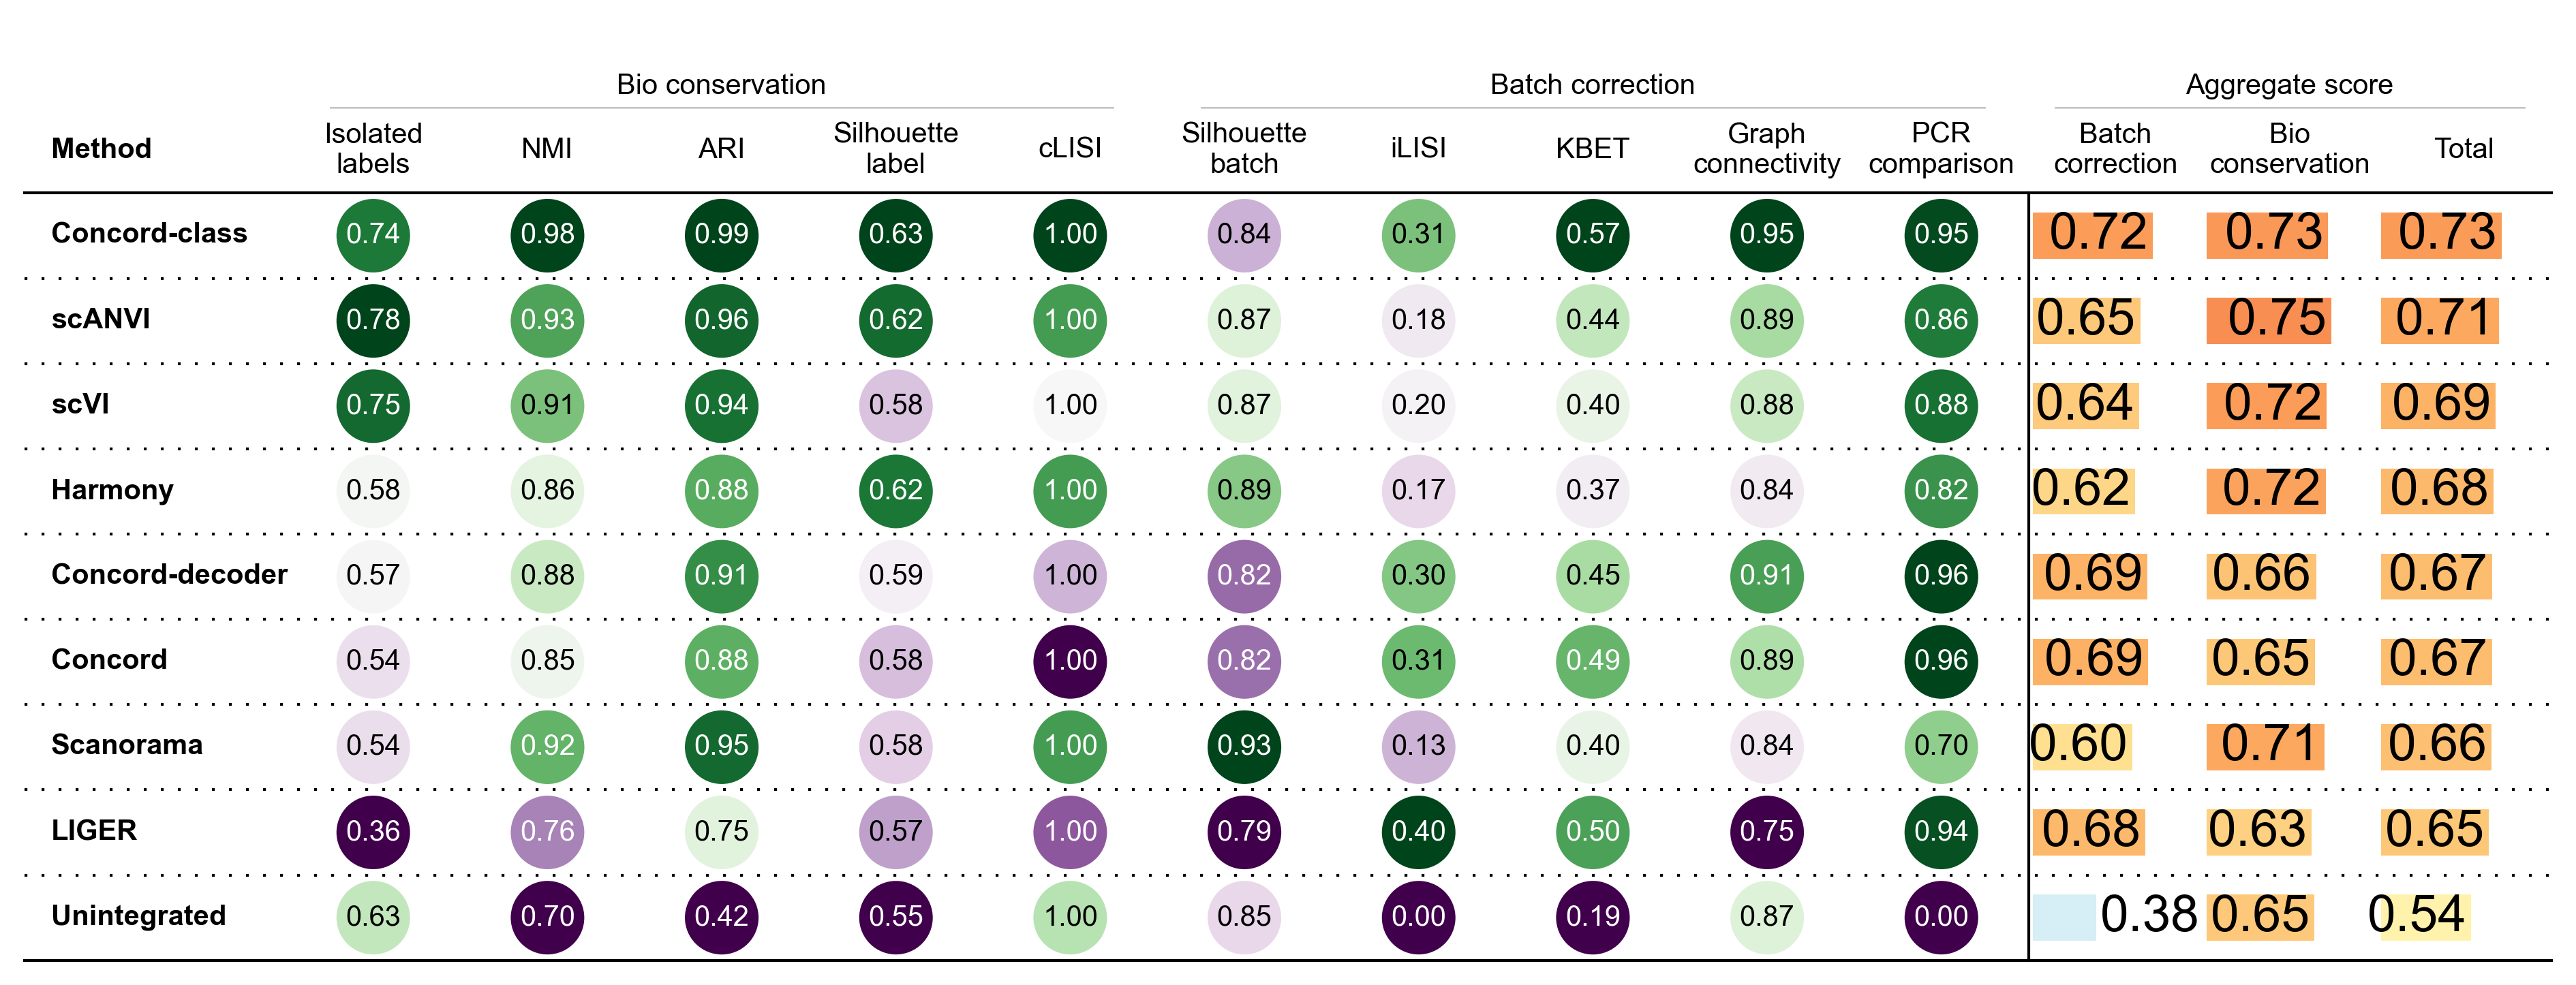

In [175]:
import pandas as pd
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Benchmarking hyperparam test

In [ ]:
# Batch run
param_grid = {
    "augmentation_mask_prob": [0.0, 0.1, 0.3, 0.5, 0.7, 0.9],
    "p_intra_knn": [0.0, 0.05, 0.1, 0.3, 0.5],
    "min_p_intra_domain": [0.3, 0.5, 0.8, 1.0],
}
ccd.ul.run_hyperparameter_tests(adata, params, param_grid, output_key='Concord', return_decoded=False, trace_memory=True, trace_gpu_memory=True, save_dir=save_dir)

params_cdt = params.copy()
params_cdt['use_classifier'] = True
param_grid = {
    "augmentation_mask_prob": [0.0, 0.1, 0.3, 0.5, 0.7, 0.9],
    "p_intra_knn": [0.0, 0.05, 0.1, 0.3, 0.5],
    "min_p_intra_domain": [0.3, 0.5, 0.8, 1.0],
}
ccd.ul.run_hyperparameter_tests(adata, params_cdt, param_grid, output_key='Concord-ant', return_decoded=False, trace_memory=True, trace_gpu_memory=True, save_dir=save_dir)


In [ ]:

file_suffix = f"{time.strftime('%b%d-%H%M')}"
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys= [key for key in adata.obsm.keys() if all(substring not in key for substring in ["UMAP"])],
    n_jobs=3
)
bm.benchmark()
ccd.ul.save_object(bm, save_dir / f"bm_{file_suffix}.pkl")
bm.get_results(min_max_scale=False).to_excel(save_dir / f"bm_results_{file_suffix}.xlsx")


In [ ]:

import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(25, 5) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=300)
plt.show()
plt.close(fig)


In [ ]:
output_key = "Concord-ant_augmentation_mask_prob_0.5"
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_epochs=500, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=seed, use_cuml=False)

show_emb = f'{output_key}_UMAP'

ccd.pl.plot_embedding(
    adata, show_emb, show_cols, figsize=(10,8), dpi=600, ncols=2, font_size=8, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_emb}_{file_suffix}.png"
)
